In [34]:
# reading data on google drive
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/other/data/Data for MSC Thesis/eth_householdgeovariables_y5.csv'
df = pd.read_csv(file_path)

print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.4   
1  20101010100104022        7.7   162.300003    82.900002             0.4   
2  20101010100104033        7.7   162.300003    82.900002             0.4   
3  20101010100104044        7.7   162.300003    82.900002             0.4   
4  20101010100104055        7.7   162.300003    82.900002             0.4   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   
2         0.0         283         307          184           47  ...   
3         0.0         283         307          184           47  ...   
4         0.0         283         307          1

In [35]:
# ------------------------------
# DATA EXPLORATION: NULL AND OUTLIER PERCENTAGE
# ------------------------------

# ------------------------------
# Step 1: Dataset Overview
# ------------------------------
print("----- Dataset Info -----")
print(df.info())

print("\n----- Dataset Shape -----")
print(df.shape)

print("\n----- Statistical Summary -----")
print(df.describe())

# ------------------------------
# Step 2: Missing Values by Percentage
# ------------------------------
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("\n----- Missing Values Summary -----")
print(missing_df.sort_values(by='Percentage', ascending=False))

# ------------------------------
# Step 3: Outlier Detection by Percentage (Numeric Columns Only)
# ------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

outlier_summary = []
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df)) * 100

    outlier_summary.append([col, outlier_count, outlier_percent])

outlier_df = pd.DataFrame(outlier_summary, columns=['Column', 'Outlier Count', 'Outlier %'])
print("\n----- Outlier Summary by Percentage -----")
print(outlier_df.sort_values(by='Outlier %', ascending=False))

----- Dataset Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_id       4890 non-null   int64  
 1   dist_road          4890 non-null   float64
 2   dist_market        4890 non-null   float64
 3   dist_border        4890 non-null   float64
 4   dist_popcenter     4890 non-null   float64
 5   dist_admhq         4890 non-null   float64
 6   af_bio_1_x         4890 non-null   int64  
 7   af_bio_8_x         4890 non-null   int64  
 8   af_bio_12_x        4890 non-null   int64  
 9   af_bio_13_x        4890 non-null   int64  
 10  af_bio_16_x        4890 non-null   int64  
 11  afmnslp_pct        4890 non-null   int64  
 12  srtm_1k            4890 non-null   int64  
 13  popdensity         4890 non-null   int64  
 14  cropshare          4890 non-null   int64  
 15  sq1                4890 non-null   int64  
 16 

In [36]:
# check number of distinic catagory
for col in ['ssa_aez09', 'landcov']:
    print(f"\nColumn: {col}")
    print("Number of distinct categories:", df[col].nunique())
    print("Categories:", df[col].unique())



Column: ssa_aez09
Number of distinct categories: 7
Categories: ['Tropic-warm/semiarid' 'Tropic-warm/arid' 'Tropic-cool/subhumid'
 'Tropic-cool/semiarid' 'Tropic-cool/humid' 'Tropic-cool/arid'
 'Tropic-warm/subhumid']

Column: landcov
Number of distinct categories: 9
Categories: ['Bare/sparse vegetation' 'Cropland' 'Built-up' 'Shrubs'
 'Herbaceous vegetation' 'Open forest unknown'
 'Closed forest deciduous broad leaf' 'Closed forest evergreen broad leaf'
 'Open forest deciduous broad leaf']


In [37]:
#----------------------------------------
#1 Drop columns with more than 40% missing
#----------------------------------------
missing_threshold = 0.4
cols_to_drop = df.columns[df.isnull().mean() > missing_threshold]

print("Dropping columns:", cols_to_drop.tolist())
df = df.drop(columns=cols_to_drop)

# 2. Remove spatial leakage
df = df.drop(columns=['lat_dd_mod', 'lon_dd_mod'], errors='ignore')

# 3. Winsorize numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    if col not in ['household_id', 'AI_pca1']:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)

Dropping columns: ['c2_eviarea_avg', 'c2_evimax_avg', 'c2_grn_avg', 'c2_sen_avg', 'c2_h2021_eviarea', 'c2_h2021_evimax', 'c2_h2021_grn', 'c2_h2021_sen']


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_id       4890 non-null   int64  
 1   dist_road          4890 non-null   float64
 2   dist_market        4890 non-null   float64
 3   dist_border        4890 non-null   float64
 4   dist_popcenter     4890 non-null   float64
 5   dist_admhq         4890 non-null   float64
 6   af_bio_1_x         4890 non-null   int64  
 7   af_bio_8_x         4890 non-null   int64  
 8   af_bio_12_x        4890 non-null   int64  
 9   af_bio_13_x        4890 non-null   int64  
 10  af_bio_16_x        4890 non-null   int64  
 11  afmnslp_pct        4890 non-null   int64  
 12  srtm_1k            4890 non-null   int64  
 13  popdensity         4890 non-null   int64  
 14  cropshare          4890 non-null   int64  
 15  sq1                4890 non-null   int64  
 16  sq2                4890 

In [39]:
# ==============================
# 2. Check columns
# ==============================
print("Before Encoding:")
print(df[['ssa_aez09','landcov']].head())

# ==============================
# 4. One-Hot Encode categorical columns
# ==============================
df_encoded = pd.get_dummies(
    df,
    columns=['ssa_aez09', 'landcov'],
    drop_first=True   # avoids multicollinearity (important for regression)
)

# ==============================
# 5. View results
# ==============================
print("\nAfter Encoding:")
print(df_encoded.head())

print("\nNew columns created:")
new_cols = [col for col in df_encoded.columns if 'ssa_aez09_' in col or 'landcov_' in col]
print(new_cols)

# ==============================
# 6. Check dataset shape
# ==============================
print("\nOriginal shape:", df.shape)
print("Encoded shape:", df_encoded.shape)

# change to boolean to numerical value
#bool_cols = df_encoded.select_dtypes(include='bool').columns
#df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df=df_encoded.copy()

Before Encoding:
              ssa_aez09                 landcov
0  Tropic-warm/semiarid  Bare/sparse vegetation
1  Tropic-warm/semiarid  Bare/sparse vegetation
2  Tropic-warm/semiarid  Bare/sparse vegetation
3  Tropic-warm/semiarid  Bare/sparse vegetation
4  Tropic-warm/semiarid  Bare/sparse vegetation

After Encoding:
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.5   
1  20101010100104022        7.7   162.300003    82.900002             0.5   
2  20101010100104033        7.7   162.300003    82.900002             0.5   
3  20101010100104044        7.7   162.300003    82.900002             0.5   
4  20101010100104055        7.7   162.300003    82.900002             0.5   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   

🔧 UPDATED DATA PREPROCESSING WITH ACCESSIBILITY INDEX

1. CREATING ACCESSIBILITY INDEX (TARGET)
--------------------------------------------------
AI_pca1 created ✓  Range: -1.593 to 6.880
Accessibility Classes: {'Low': 1652, 'High': 1628, 'Medium': 1610}
✅ Target variables created successfully!


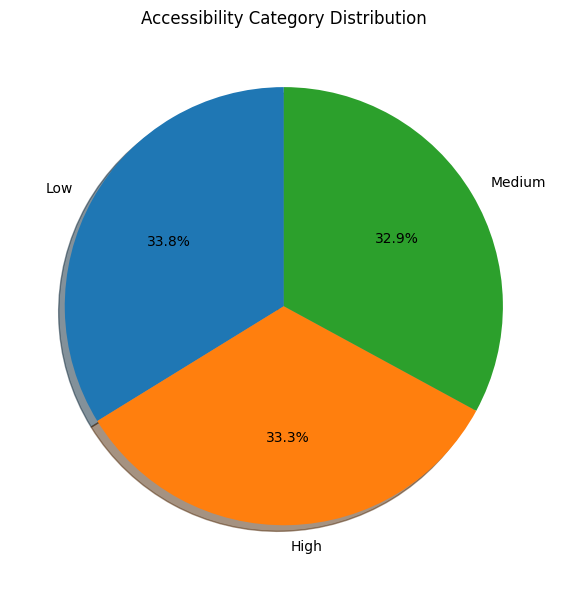

In [41]:
# =============================================================================
# CELL 1: COMPREHENSIVE DATA PREPROCESSING (UPDATED WITH AI + CLASS TARGET)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("🔧 UPDATED DATA PREPROCESSING WITH ACCESSIBILITY INDEX")
print("=" * 60)

# =============================================================================
# 1. CREATE TARGET VARIABLE: ACCESSIBILITY INDEX (TARGET)
# =============================================================================
print("\n1. CREATING ACCESSIBILITY INDEX (TARGET)")
print("-" * 50)

# 5 distance columns (required for AI)
dist_cols = ['dist_road', 'dist_market', 'dist_popcenter',
             'dist_border', 'dist_admhq']

# --- Standardize distance variables ---
scaler_ai = StandardScaler()
Z = scaler_ai.fit_transform(df[dist_cols])

# --- PCA to compute Accessibility Index ---
pca = PCA(n_components=1)
df['AI_pca1'] = pca.fit_transform(Z)[:, 0]  # continuous target

print(f"AI_pca1 created ✓  Range: {df['AI_pca1'].min():.3f} to {df['AI_pca1'].max():.3f}")

# ------------------------------
# Create 3-class Accessibility Category
# ------------------------------
q33 = df['AI_pca1'].quantile(0.33)
q66 = df['AI_pca1'].quantile(0.66)

def classify_access(x):
    if x <= q33:
        return "High"       # best access
    elif x <= q66:
        return "Medium"
    else:
        return "Low"        # worst access

df['accessibility_category'] = df['AI_pca1'].apply(classify_access)

print("Accessibility Classes:", df['accessibility_category'].value_counts().to_dict())
print("✅ Target variables created successfully!")

# =============================================================================
# VISUALIZATION
# =============================================================================

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(7, 6))

# Pie chart of accessibility categories
df['accessibility_category'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    ax=axes,
    startangle=90,
    shadow=True
)

axes.set_ylabel("")  # remove default label
axes.set_title("Accessibility Category Distribution")

plt.tight_layout()
plt.show()


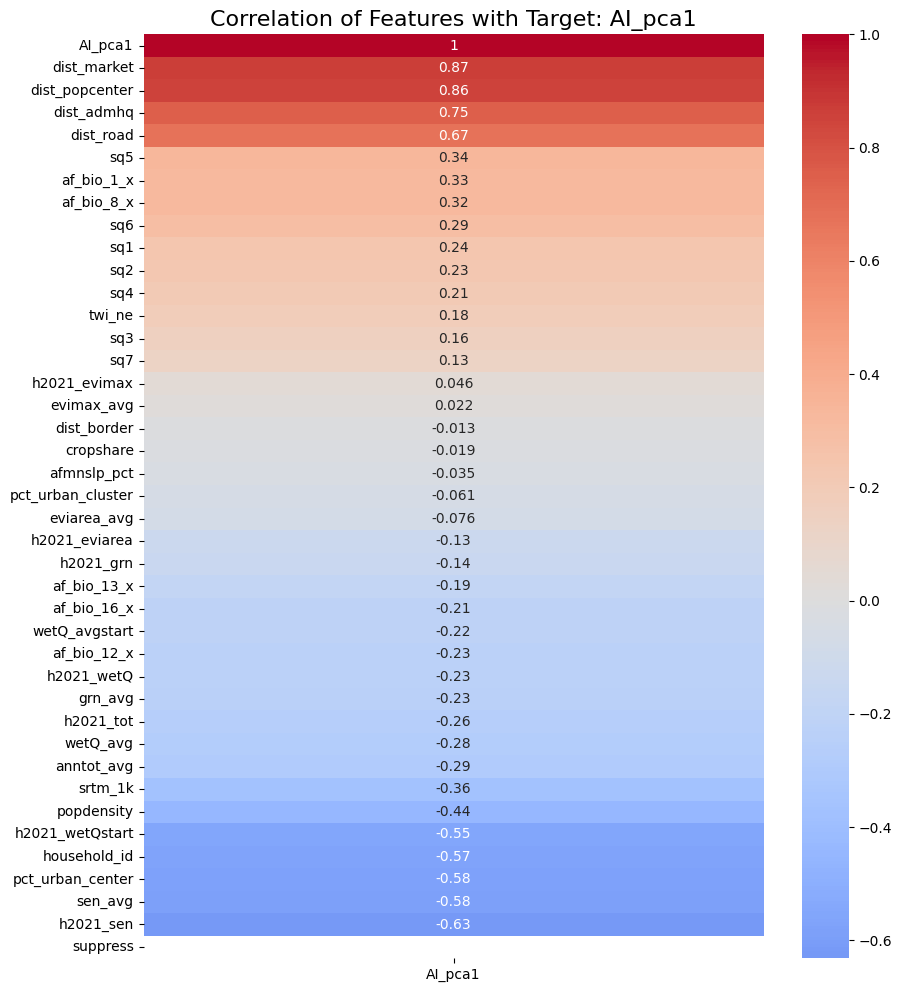

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your dataset with renamed columns

# Step 1: Choose target column
target = 'AI_pca1'

# Step 2: Select numeric columns only
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Step 3: Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Step 4: Focus on correlations with target
target_corr = corr_matrix[[target]].sort_values(by=target, ascending=False)

# Step 5: Plot heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation of Features with Target: {target}', fontsize=16)
plt.show()

In [52]:
# ------------------------------
# FULL PREPROCESSING PIPELINE WITH SMOTE (NO WARNINGS)
# ------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# ------------------------------
# Step 1: Drop irrelevant/correlated columns
# ------------------------------

cols_to_drop = [
    'household_id',
    'dist_road',
    'dist_market',
    'dist_border',
    'dist_popcenter',
    'dist_admhq','suppress'
]

df = df.drop(columns=cols_to_drop, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   af_bio_1_x                                  4890 non-null   int64  
 1   af_bio_8_x                                  4890 non-null   int64  
 2   af_bio_12_x                                 4890 non-null   int64  
 3   af_bio_13_x                                 4890 non-null   int64  
 4   af_bio_16_x                                 4890 non-null   int64  
 5   afmnslp_pct                                 4890 non-null   int64  
 6   srtm_1k                                     4890 non-null   int64  
 7   popdensity                                  4890 non-null   int64  
 8   cropshare                                   4890 non-null   int64  
 9   sq1                                         4890 non-null   int64  
 10  sq2         

In [67]:
# ===============================
# Define targets
# ===============================
y_reg = df['AI_pca1']                     # regression
y_cls = df['accessibility_category']      # classification

# ===============================
# Define features (remove targets)
# ===============================
X = df.drop(columns=['AI_pca1','accessibility_category'])

bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

In [68]:
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=0.95)  # retain 95% variance
X_reduced = pca.fit_transform(X_scaled)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train_r = scaler.fit_transform(X_train_r)
X_test_r  = scaler.transform(X_test_r)

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

rf_reg = RandomForestRegressor(n_estimators=300, random_state=42)
rf_reg.fit(X_train_r, y_train_r)

pred_r = rf_reg.predict(X_test_r)

print("R2:", r2_score(y_test_r, pred_r))
print("MAE:", mean_absolute_error(y_test_r, pred_r))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, pred_r)))

R2: 0.9985818750112375
MAE: 0.0067856047420875205
RMSE: 0.06047618465674985


In [65]:
from sklearn.preprocessing import StandardScaler
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

scaler = StandardScaler()

X_train_c = scaler.fit_transform(X_train_c)
X_test_c  = scaler.transform(X_test_c)


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_clf = RandomForestClassifier(n_estimators=300, random_state=42)
rf_clf.fit(X_train_c, y_train_c)

pred_c = rf_clf.predict(X_test_c)

print("Accuracy:", accuracy_score(y_test_c, pred_c))
print("\nClassification Report:\n", classification_report(y_test_c, pred_c))

Accuracy: 0.9969325153374233

Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00       326
         Low       1.00      1.00      1.00       330
      Medium       0.99      1.00      1.00       322

    accuracy                           1.00       978
   macro avg       1.00      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978




COMPREHENSIVE CORRELATION AND VIF ANALYSIS

1. PREPARING ALL DATA COLUMNS
----------------------------------------
Total numerical columns in df: 34
Including target column: AI_pca1

Analyzing 34 columns total:

2. CORRELATION HEATMAP (WITH VALUES)
----------------------------------------


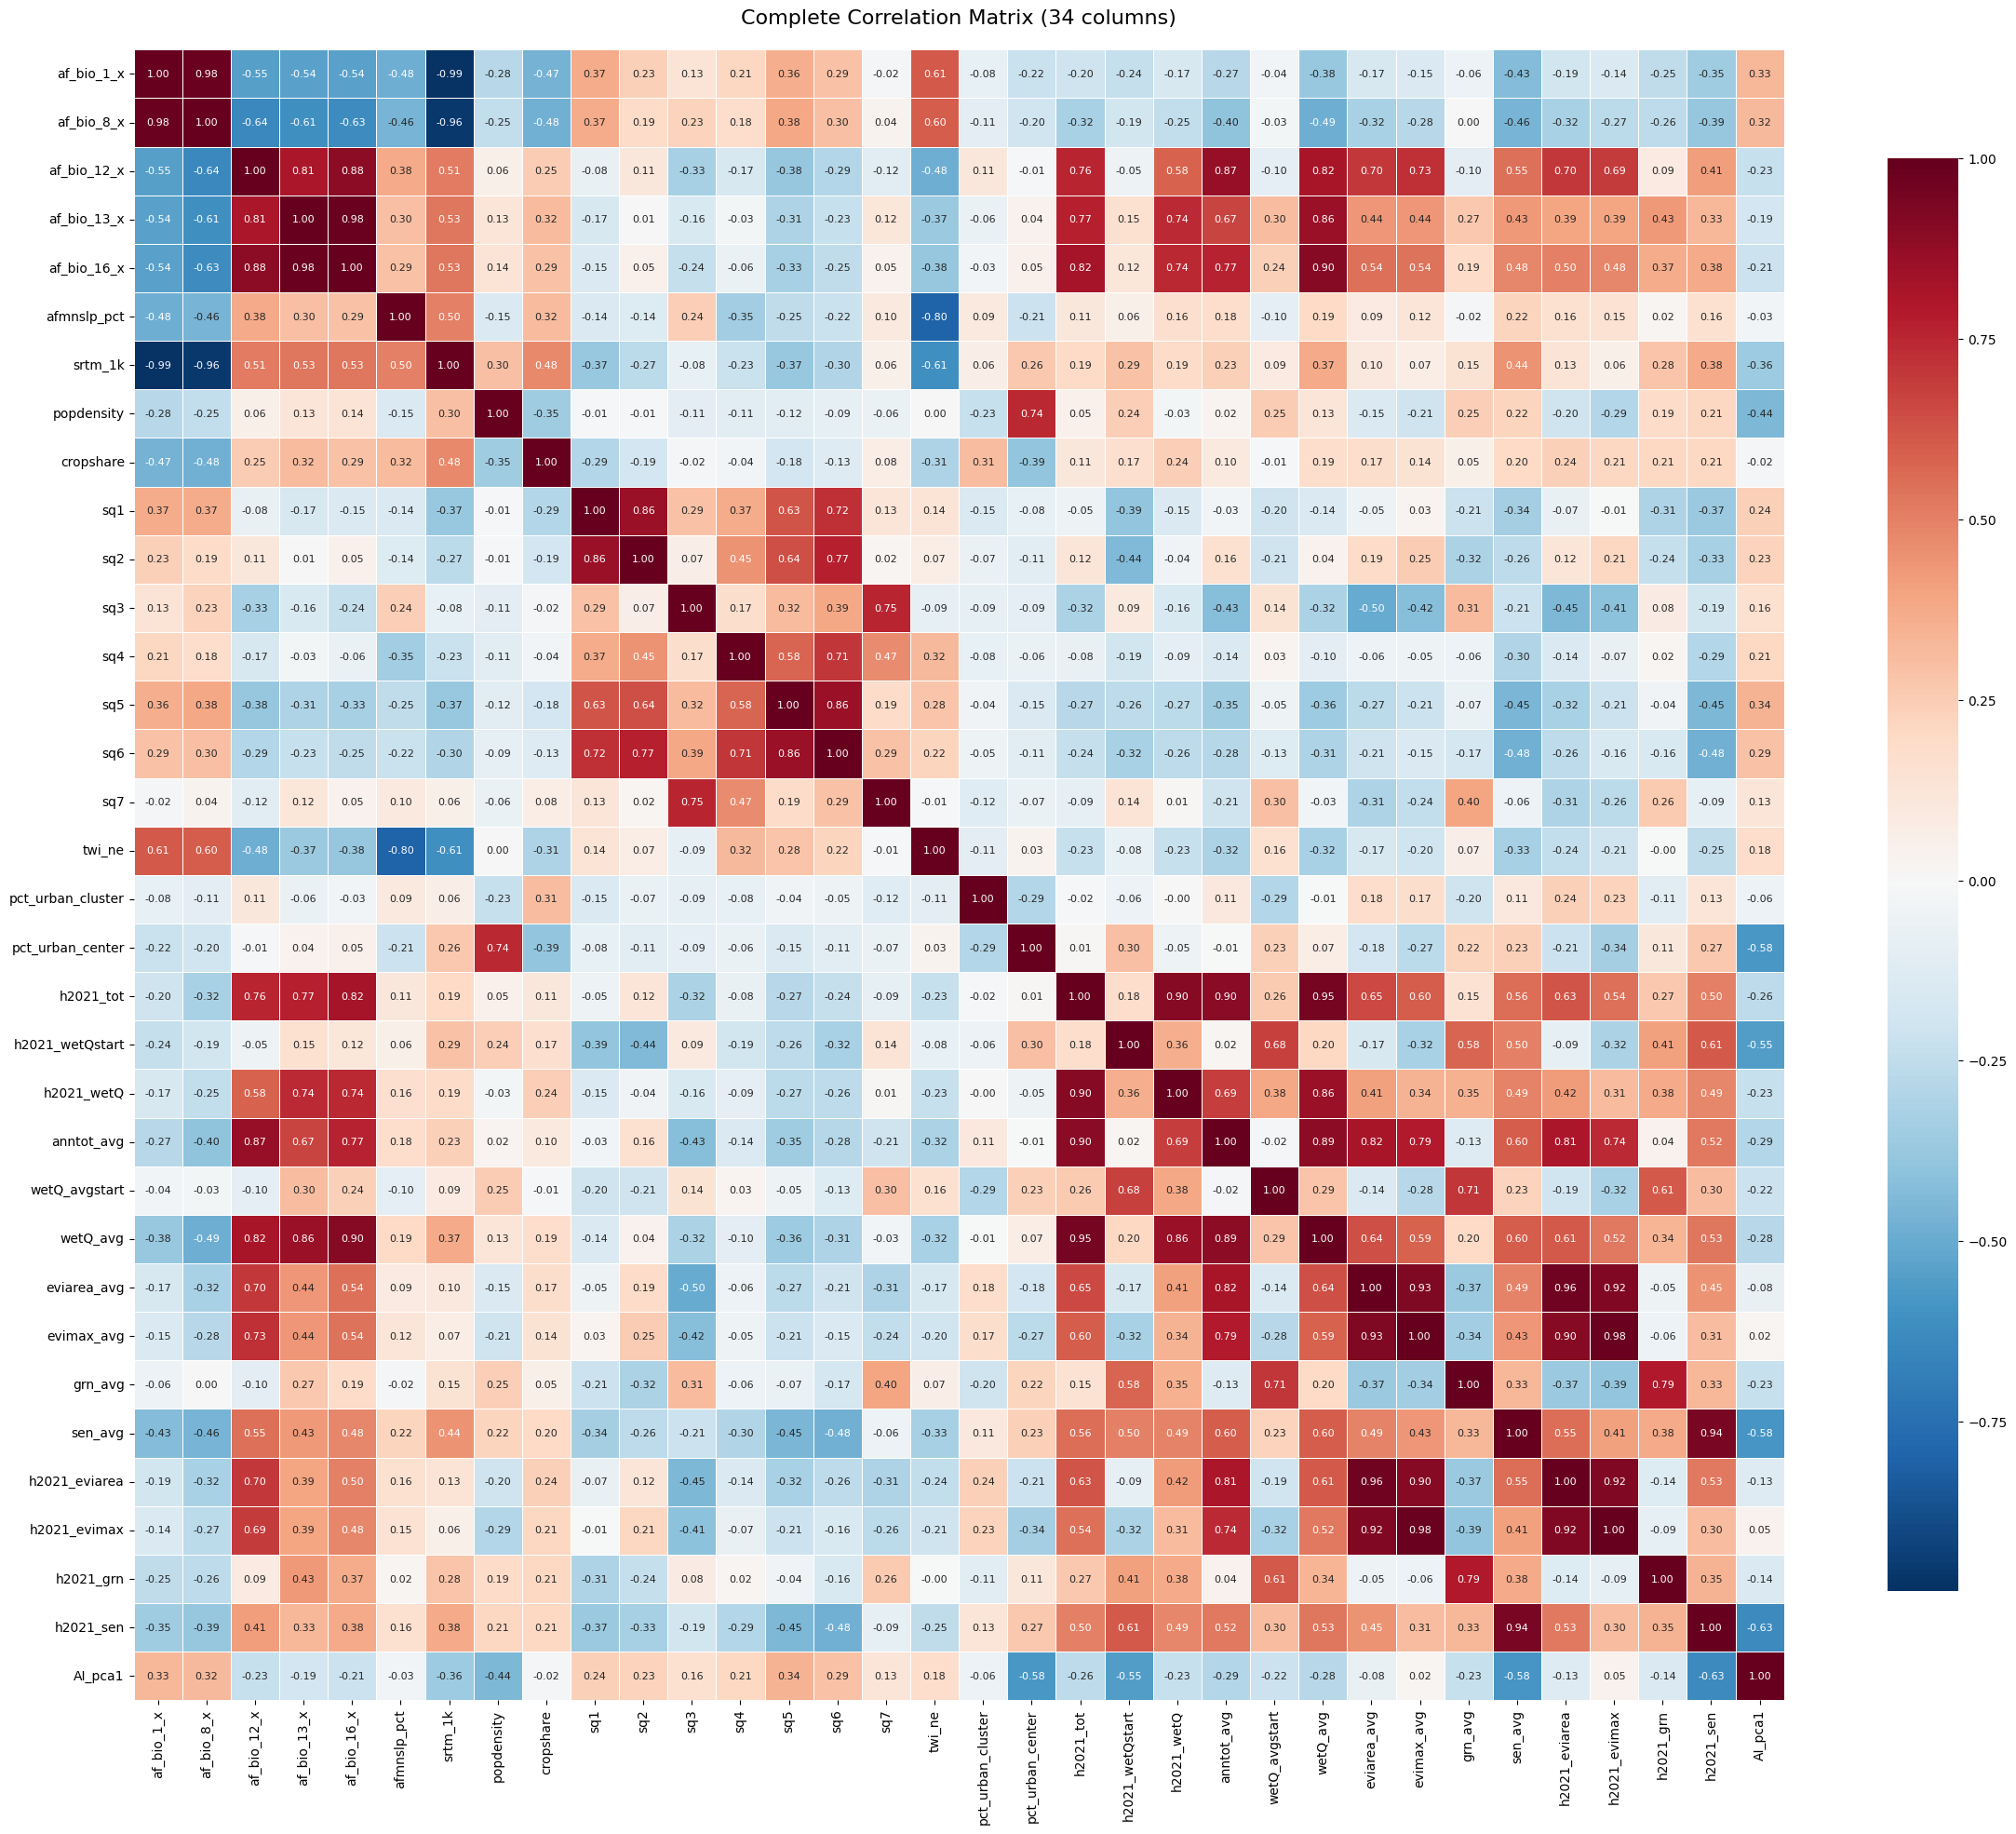


3. TARGET CORRELATION ANALYSIS
----------------------------------------

Top 10 features correlated with AI_pca1:
--------------------------------------------------
 1. h2021_sen                      :  -0.632 (negative)
 2. sen_avg                        :  -0.583 (negative)
 3. pct_urban_center               :  -0.576 (negative)
 4. h2021_wetQstart                :  -0.553 (negative)
 5. popdensity                     :  -0.443 (negative)
 6. srtm_1k                        :  -0.364 (negative)
 7. sq5                            :   0.342 (positive)
 8. af_bio_1_x                     :   0.329 (positive)
 9. af_bio_8_x                     :   0.324 (positive)
10. sq6                            :   0.294 (positive)


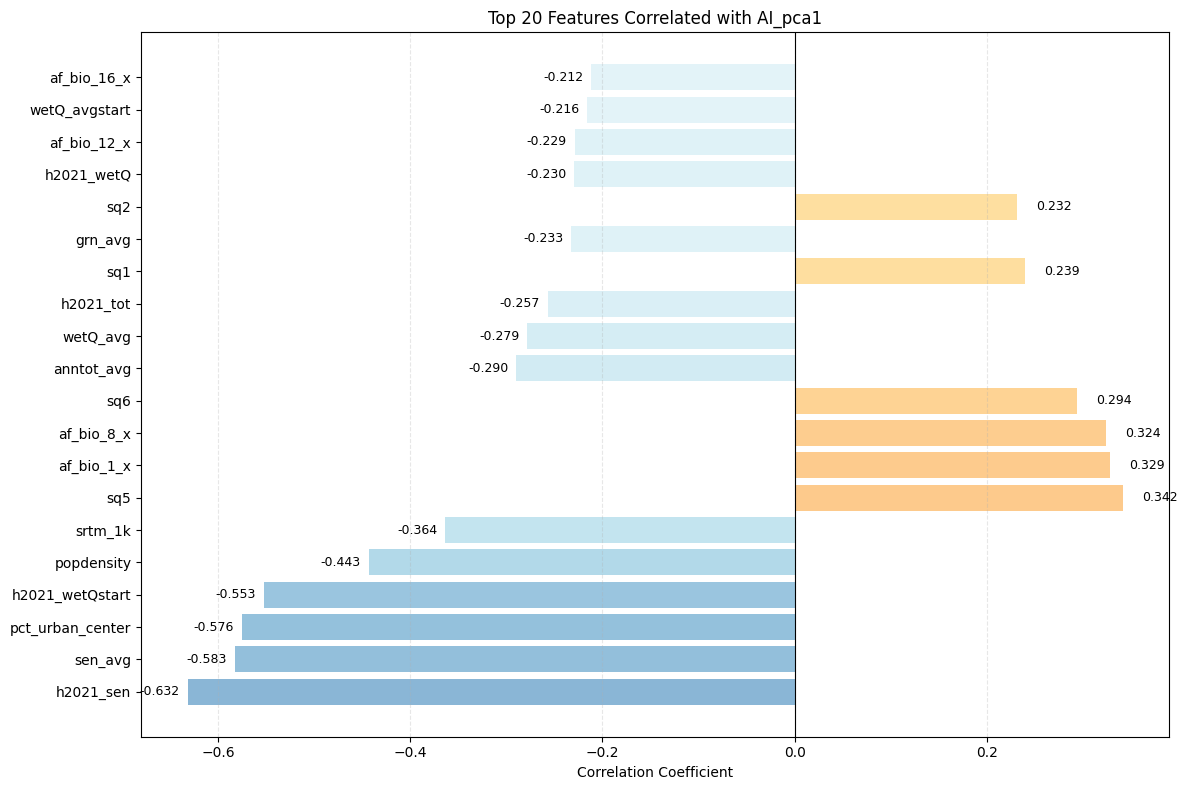


4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES
----------------------------------------
Calculating VIF for 33 features...

VIF RESULTS SUMMARY:
------------------------------------------------------------
Feature                        VIF      Status      
------------------------------------------------------------
🔴 af_bio_16_x                    167.17 HIGH VIF    
🔴 af_bio_8_x                     165.72 HIGH VIF    
🔴 h2021_evimax                   161.51 HIGH VIF    
🔴 af_bio_1_x                     148.07 HIGH VIF    
🔴 h2021_eviarea                  125.05 HIGH VIF    
🔴 evimax_avg                     120.09 HIGH VIF    
🔴 srtm_1k                        110.31 HIGH VIF    
🔴 af_bio_13_x                     98.54 HIGH VIF    
🔴 eviarea_avg                     87.09 HIGH VIF    
🔴 h2021_tot                       71.67 HIGH VIF    
🔴 anntot_avg                      69.33 HIGH VIF    
🔴 wetQ_avg                        59.13 HIGH VIF    
🔴 h2021_wetQ                      40.14 HIGH VI

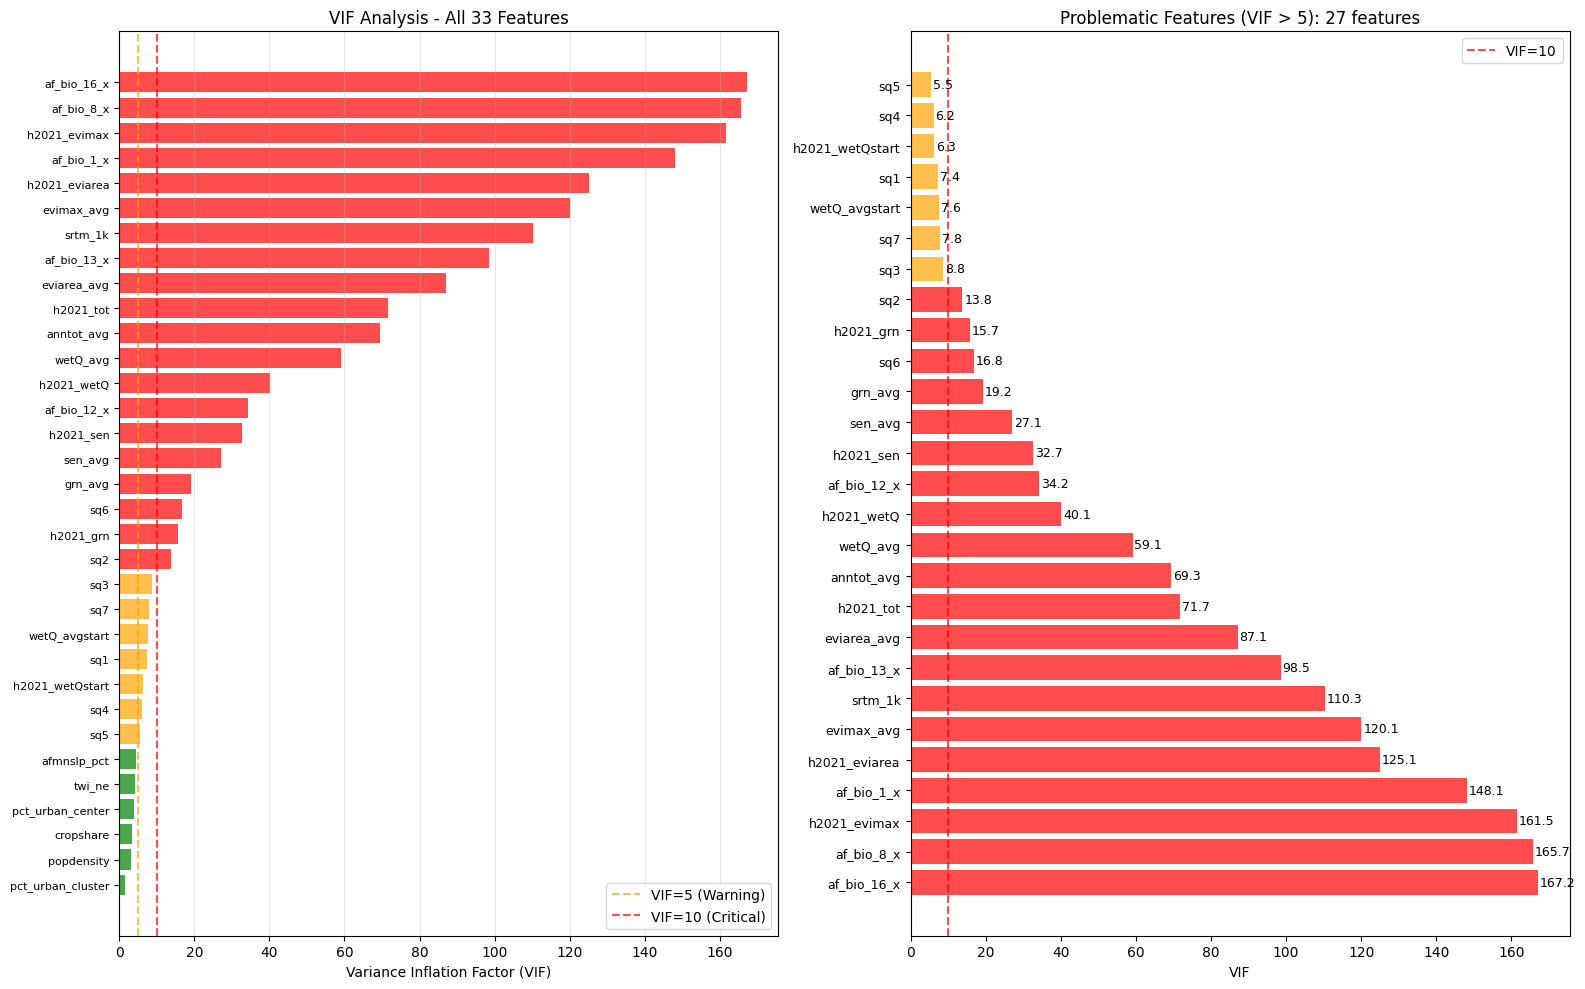


6. HIGHLY CORRELATED FEATURE PAIRS
----------------------------------------
Found 28 pairs with |correlation| > 0.8:
--------------------------------------------------------------------------------
Feature 1                      Feature 2                      Correlation 
--------------------------------------------------------------------------------
af_bio_1_x                     srtm_1k                              -0.985
evimax_avg                     h2021_evimax                          0.983
af_bio_13_x                    af_bio_16_x                           0.982
af_bio_1_x                     af_bio_8_x                            0.979
eviarea_avg                    h2021_eviarea                         0.963
af_bio_8_x                     srtm_1k                              -0.958
h2021_tot                      wetQ_avg                              0.947
sen_avg                        h2021_sen                             0.939
eviarea_avg                    evimax_avg    

In [71]:
# =============================================================================
# CORRELATION & VIF ANALYSIS - COMPLETE VERSION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

print("\n" + "="*60)
print("COMPREHENSIVE CORRELATION AND VIF ANALYSIS")
print("="*60)

# =============================================================================
# 1. PREPARE DATA WITH ALL COLUMNS
# =============================================================================
print("\n1. PREPARING ALL DATA COLUMNS")
print("-"*40)

# Get ALL numerical columns from original dataframe
all_numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total numerical columns in df: {len(all_numerical_cols)}")

# Create DataFrame with ALL numerical columns + target
full_data = df[all_numerical_cols].copy()

# Make sure AI_pca1 is included (it's already in df from your preprocessing)
print(f"Including target column: AI_pca1")

# Display column count
print(f"\nAnalyzing {len(full_data.columns)} columns total:")

# =============================================================================
# 2. COMPREHENSIVE CORRELATION HEATMAP WITH NUMBERS
# =============================================================================
print("\n2. CORRELATION HEATMAP (WITH VALUES)")
print("-"*40)

# Calculate correlation matrix
corr_matrix = full_data.corr()

# Determine figure size based on number of columns
n_cols = len(corr_matrix.columns)
fig_width = max(20, n_cols * 0.7)
fig_height = max(18, n_cols * 0.6)

plt.figure(figsize=(fig_width, fig_height))

# Create heatmap with numbers
sns.heatmap(corr_matrix,
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            annot=True,  # Show numbers
            annot_kws={'size': 8},  # Font size for numbers
            fmt='.2f',  # Format numbers to 2 decimal places
            xticklabels=True,
            yticklabels=True)

plt.title(f'Complete Correlation Matrix ({n_cols} columns)', fontsize=16, pad=20)
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# =============================================================================
# 3. TARGET-SPECIFIC CORRELATION ANALYSIS
# =============================================================================
print("\n3. TARGET CORRELATION ANALYSIS")
print("-"*40)

# Find correlations with AI_pca1
if 'AI_pca1' in corr_matrix.columns:
    target_corrs = corr_matrix['AI_pca1'].drop('AI_pca1').sort_values(key=abs, ascending=False)

    print(f"\nTop 10 features correlated with AI_pca1:")
    print("-"*50)
    for i, (feat, corr) in enumerate(target_corrs.head(10).items(), 1):
        direction = "positive" if corr > 0 else "negative"
        print(f"{i:2}. {feat:30} : {corr:7.3f} ({direction})")

    # Plot top correlations
    plt.figure(figsize=(12, 8))
    top_20 = target_corrs.head(20)

    # Create color gradient
    colors = plt.cm.RdYlBu_r((top_20.values + 1) / 2)

    bars = plt.barh(range(len(top_20)), top_20.values, color=colors, alpha=0.8)
    plt.yticks(range(len(top_20)), top_20.index)
    plt.axvline(x=0, color='black', linewidth=0.8)
    plt.xlabel('Correlation Coefficient')
    plt.title('Top 20 Features Correlated with AI_pca1')
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # Add correlation values on bars
    for i, (bar, val) in enumerate(zip(bars, top_20.values)):
        x_pos = val + (0.02 if val >= 0 else -0.05)
        plt.text(x_pos, i, f'{val:.3f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES
# =============================================================================
print("\n4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES")
print("-"*40)

# Remove target column for VIF calculation (if present)
features_for_vif = [col for col in full_data.columns if col != 'AI_pca1']
X_for_vif = full_data[features_for_vif].copy()

print(f"Calculating VIF for {len(X_for_vif.columns)} features...")

# Calculate VIF
def calculate_vif_safe(X_df, max_features=50):
    """Calculate VIF safely handling large datasets"""
    if len(X_df.columns) > max_features:
        print(f"  Note: Calculating VIF for {len(X_df.columns)} features may take time...")

    X_const = add_constant(X_df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_const.columns

    vif_values = []
    for i in range(X_const.shape[1]):
        try:
            vif = variance_inflation_factor(X_const.values, i)
            vif_values.append(vif)
        except:
            vif_values.append(np.nan)

    vif_data["VIF"] = vif_values
    vif_data = vif_data[vif_data['feature'] != 'const']
    return vif_data.sort_values('VIF', ascending=False)

vif_results = calculate_vif_safe(X_for_vif)

print(f"\nVIF RESULTS SUMMARY:")
print("-"*60)
print(f"{'Feature':30} {'VIF':8} {'Status':12}")
print("-"*60)

# Display results with categorization
for _, row in vif_results.iterrows():
    vif_val = row['VIF']
    if pd.isna(vif_val):
        status = "ERROR"
        symbol = "❌"
    elif vif_val > 10:
        status = "HIGH VIF"
        symbol = "🔴"
    elif vif_val > 5:
        status = "MODERATE"
        symbol = "🟡"
    else:
        status = "OK"
        symbol = "🟢"

    print(f"{symbol} {row['feature']:28} {vif_val:8.2f} {status:12}")

# =============================================================================
# 5. VIF VISUALIZATION
# =============================================================================
print("\n5. VIF VISUALIZATION")
print("-"*40)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Plot 1: All VIF values
vif_sorted = vif_results.sort_values('VIF')
axes[0].barh(range(len(vif_sorted)), vif_sorted['VIF'],
             color=['red' if v > 10 else 'orange' if v > 5 else 'green'
                    for v in vif_sorted['VIF']],
             alpha=0.7)
axes[0].set_yticks(range(len(vif_sorted)))
axes[0].set_yticklabels(vif_sorted['feature'], fontsize=8)
axes[0].axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='VIF=5 (Warning)')
axes[0].axvline(x=10, color='red', linestyle='--', alpha=0.7, label='VIF=10 (Critical)')
axes[0].set_xlabel('Variance Inflation Factor (VIF)')
axes[0].set_title(f'VIF Analysis - All {len(vif_sorted)} Features')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Problematic features only
problematic = vif_results[vif_results['VIF'] > 5]
if len(problematic) > 0:
    axes[1].barh(range(len(problematic)), problematic['VIF'],
                 color=['red' if v > 10 else 'orange' for v in problematic['VIF']],
                 alpha=0.7)
    axes[1].set_yticks(range(len(problematic)))
    axes[1].set_yticklabels(problematic['feature'], fontsize=9)
    axes[1].axvline(x=10, color='red', linestyle='--', alpha=0.7, label='VIF=10')
    axes[1].set_xlabel('VIF')
    axes[1].set_title(f'Problematic Features (VIF > 5): {len(problematic)} features')
    axes[1].legend()

    # Add VIF values on bars
    for i, (_, row) in enumerate(problematic.iterrows()):
        axes[1].text(row['VIF'] + 0.5, i, f'{row["VIF"]:.1f}',
                    va='center', fontsize=9)
else:
    axes[1].text(0.5, 0.5, 'No VIF issues!\nAll features have VIF < 5',
                ha='center', va='center', transform=axes[1].transAxes,
                fontsize=14, color='green')
    axes[1].set_title('No Multicollinearity Issues')

plt.tight_layout()
plt.show()

# =============================================================================
# 6. HIGHLY CORRELATED FEATURE PAIRS
# =============================================================================
print("\n6. HIGHLY CORRELATED FEATURE PAIRS")
print("-"*40)

threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            feat1, feat2 = corr_matrix.columns[i], corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_val))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} pairs with |correlation| > {threshold}:")
    print("-"*80)
    print(f"{'Feature 1':30} {'Feature 2':30} {'Correlation':12}")
    print("-"*80)

    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"{feat1:30} {feat2:30} {corr:12.3f}")
else:
    print(f"No feature pairs found with |correlation| > {threshold}")

# =============================================================================
# 7. COMPREHENSIVE SUMMARY
# =============================================================================
print("\n" + "="*60)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*60)

# Summary statistics
high_vif = vif_results[vif_results['VIF'] > 10]
moderate_vif = vif_results[(vif_results['VIF'] > 5) & (vif_results['VIF'] <= 10)]

print(f"\n📊 SUMMARY STATISTICS:")
print(f"  • Total columns analyzed: {len(full_data.columns)}")
print(f"  • Features with HIGH VIF (>10): {len(high_vif)}")
print(f"  • Features with MODERATE VIF (5-10): {len(moderate_vif)}")
print(f"  • Highly correlated pairs (|r| > 0.8): {len(high_corr_pairs)}")
print(f"  • Maximum VIF: {vif_results['VIF'].max():.2f}")
print(f"  • Average VIF: {vif_results['VIF'].mean():.2f}")

# Top correlations with target
if 'AI_pca1' in corr_matrix.columns:
    top_target_corr = target_corrs.head(3)
    print(f"\n🎯 TOP FEATURES FOR TARGET PREDICTION:")
    for feat, corr in top_target_corr.items():
        vif_val = vif_results[vif_results['feature'] == feat]['VIF'].values[0] if feat in vif_results['feature'].values else np.nan
        print(f"  • {feat}: correlation = {corr:.3f}, VIF = {vif_val:.2f}")

# Recommendations
print(f"\n⚠️  RECOMMENDATIONS:")
if len(high_vif) > 0:
    print(f"  1. Consider removing features with VIF > 10:")
    for _, row in high_vif.head(5).iterrows():
        print(f"     - {row['feature']} (VIF = {row['VIF']:.1f})")
if len(high_corr_pairs) > 0:
    print(f"  2. Check these highly correlated pairs for redundancy")
if len(high_vif) == 0 and len(high_corr_pairs) == 0:
    print("  ✓ No major multicollinearity issues detected!")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

# Store results for later use
analysis_results = {
    'correlation_matrix': corr_matrix,
    'vif_results': vif_results,
    'high_correlation_pairs': high_corr_pairs,
    'target_correlations': target_corrs if 'AI_pca1' in corr_matrix.columns else None
}

print("\nResults stored in 'analysis_results' dictionary")

In [60]:
# Example: dropping one of each high-corr pair
cols_to_drop = [
    'af_bio_1_x', 'evimax_avg', 'eviarea_avg',
    'af_bio_13_x', 'af_bio_8_x', 'sq2',
    'h2021_wetQ', 'wetQ_avg'  # optional depending on model
]

X = X.drop(columns=cols_to_drop)

In [ ]:
# %% CELL 1 - IMPORTS & LOAD PREPROCESSED DATA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Optional model imports (XGBoost / LightGBM). If not installed, code gracefully skips them.
try:
    from xgboost import XGBRegressor, XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

try:
    from lightgbm import LGBMRegressor, LGBMClassifier
    lgb_available = True
except Exception:
    lgb_available = False

# Load preprocessed data (created previously)
# The preprocessing cell should have created a dict named `preprocessed_data`
# with keys: 'X_train', 'X_test', 'y_train', 'y_test', 'y_train_class', 'y_test_class', 'feature_names', 'scaler', 'X_original'
try:
    pdata = preprocessed_data
except NameError:
    raise RuntimeError("preprocessed_data not found. Run the preprocessing cell first.")

X_train = pd.DataFrame(pdata['X_train'], columns=pdata['feature_names'])
X_test = pd.DataFrame(pdata['X_test'], columns=pdata['feature_names'])
y_train_reg = pdata['y_train'].reset_index(drop=True)
y_test_reg = pdata['y_test'].reset_index(drop=True)
y_train_clf = pdata['y_train_class'].reset_index(drop=True)
y_test_clf = pdata['y_test_class'].reset_index(drop=True)

print("Loaded preprocessed data:")
print(" X_train:", X_train.shape, " X_test:", X_test.shape)
print(" y_train (reg):", y_train_reg.shape, " y_test (reg):", y_test_reg.shape)
print(" y_train (clf) value counts:\n", y_train_clf.value_counts())


Loaded preprocessed data:
 X_train: (3912, 9)  X_test: (978, 9)
 y_train (reg): (3912,)  y_test (reg): (978,)
 y_train (clf) value counts:
 AI_class_3
Low       1325
Medium    1296
High      1291
Name: count, dtype: int64


Training LinearRegression...
 LinearRegression  RMSE: 1.3546  R2: 0.2899
Training Ridge(alpha=1.0)...
 Ridge(alpha=1.0)  RMSE: 1.3546  R2: 0.2898
Training RandomForest...
 RandomForest  RMSE: 0.0554  R2: 0.9988
Training XGBoost...
 XGBoost  RMSE: 0.0555  R2: 0.9988
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 9
[LightGBM] [Info] Start training from score -0.004755
 LightGBM  RMSE: 0.0594  R2: 0.9986


,model,RMSE,R2
2,RandomForest,0.055431,0.998811
3,XGBoost,0.055504,0.998808
4,LightGBM,0.059384,0.998635
0,LinearRegression,1.354563,0.289904
1,Ridge(alpha=1.0),1.354632,0.289832


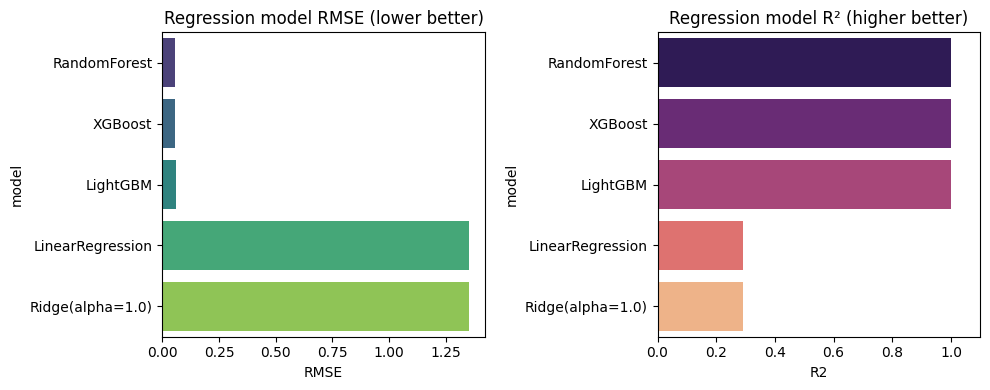


Using RandomForest for feature-importance (permutation importance).


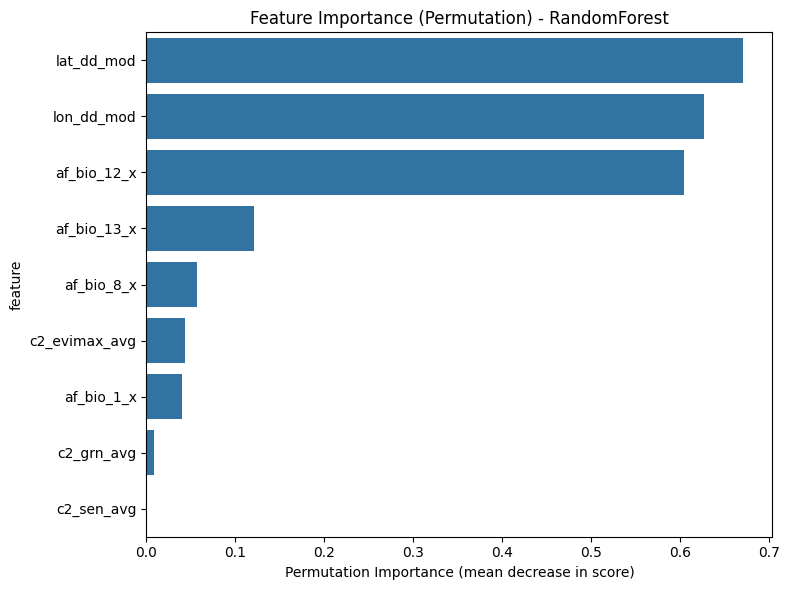

Top features: ['lat_dd_mod', 'lon_dd_mod', 'af_bio_12_x']


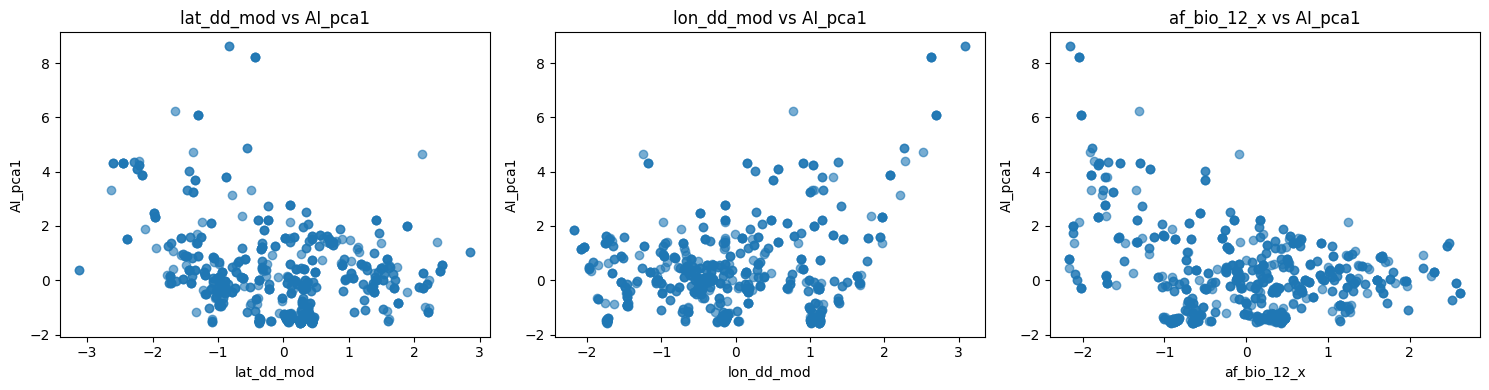

In [ ]:
# %% CELL 2 - REGRESSION: TRAIN MODELS + COMPARE (RMSE, R2) + FEATURE IMPORTANCE
import math

# 1) Define models to try
models_reg = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}
if xgb_available:
    models_reg["XGBoost"] = XGBRegressor(n_estimators=200, random_state=42, verbosity=0, n_jobs=1)
if lgb_available:
    models_reg["LightGBM"] = LGBMRegressor(n_estimators=200, random_state=42, n_jobs=-1)

results_reg = []
fitted_models_reg = {}

for name, model in models_reg.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train_reg)
    preds = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test_reg, preds))
    r2 = r2_score(y_test_reg, preds)
    results_reg.append((name, rmse, r2))
    fitted_models_reg[name] = model
    print(f" {name}  RMSE: {rmse:.4f}  R2: {r2:.4f}")

# 2) Results table & bar plots
res_df = pd.DataFrame(results_reg, columns=["model", "RMSE", "R2"]).sort_values("RMSE")
display(res_df)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(x="RMSE", y="model", data=res_df, palette="viridis")
plt.title("Regression model RMSE (lower better)")

plt.subplot(1,2,2)
sns.barplot(x="R2", y="model", data=res_df, palette="magma")
plt.title("Regression model R² (higher better)")
plt.xlim(0, max(1, res_df['R2'].max()*1.1))
plt.tight_layout()
plt.show()

# 3) Feature importance:
# Use permutation importance (model-agnostic) on best model by RMSE
best_name = res_df.iloc[0]['model']
best_model = fitted_models_reg[best_name]
print(f"\nUsing {best_name} for feature-importance (permutation importance).")

perm = permutation_importance(best_model, X_test, y_test_reg, n_repeats=20, random_state=42, n_jobs=-1)
perm_idx = np.argsort(perm.importances_mean)[::-1]

fi_df = pd.DataFrame({
    'feature': X_test.columns[perm_idx],
    'importance_mean': perm.importances_mean[perm_idx],
    'importance_std': perm.importances_std[perm_idx]
})

plt.figure(figsize=(8,6))
sns.barplot(x='importance_mean', y='feature', data=fi_df.head(15), orient='h')
plt.xlabel("Permutation Importance (mean decrease in score)")
plt.title(f"Feature Importance (Permutation) - {best_name}")
plt.tight_layout()
plt.show()

# Also show partial scatter for top 3 features vs target
top_feats = fi_df['feature'].head(3).tolist()
print("Top features:", top_feats)
fig, axs = plt.subplots(1, len(top_feats), figsize=(5*len(top_feats),4))
for i, f in enumerate(top_feats):
    axs[i].scatter(X_test[f], y_test_reg, alpha=0.6)
    axs[i].set_xlabel(f)
    axs[i].set_ylabel("AI_pca1")
    axs[i].set_title(f"{f} vs AI_pca1")
plt.tight_layout()
plt.show()


Training LinearRegression...
  Test RMSE: 0.8115 | Test R²: 0.7446
Training Ridge(alpha=1.0)...
  Test RMSE: 0.8119 | Test R²: 0.7444
Training RandomForest...
  Test RMSE: 0.0652 | Test R²: 0.9983
Training XGBoost...
  Test RMSE: 0.0650 | Test R²: 0.9984
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3322
[LightGBM] [Info] Number of data points in the train set: 3912, number of used features: 45
[LightGBM] [Info] Start training from score -0.017199
  Test RMSE: 0.0521 | Test R²: 0.9989

PERFORMANCE SUMMARY (Sorted by Test RMSE)


,Model,RMSE_Train,RMSE_Test,R²_Train,R²_Test,Overfit_Gap
4,LightGBM,0.015882,0.052144,0.999899,0.998946,-0.036262
3,XGBoost,0.022889,0.064958,0.999790,0.998364,-0.042069
2,RandomForest,0.036221,0.065242,0.999475,0.998350,-0.029021
0,LinearRegression,0.760165,0.811537,0.768592,0.744634,-0.051373
1,Ridge(alpha=1.0),0.760399,0.811898,0.768449,0.744407,-0.051499


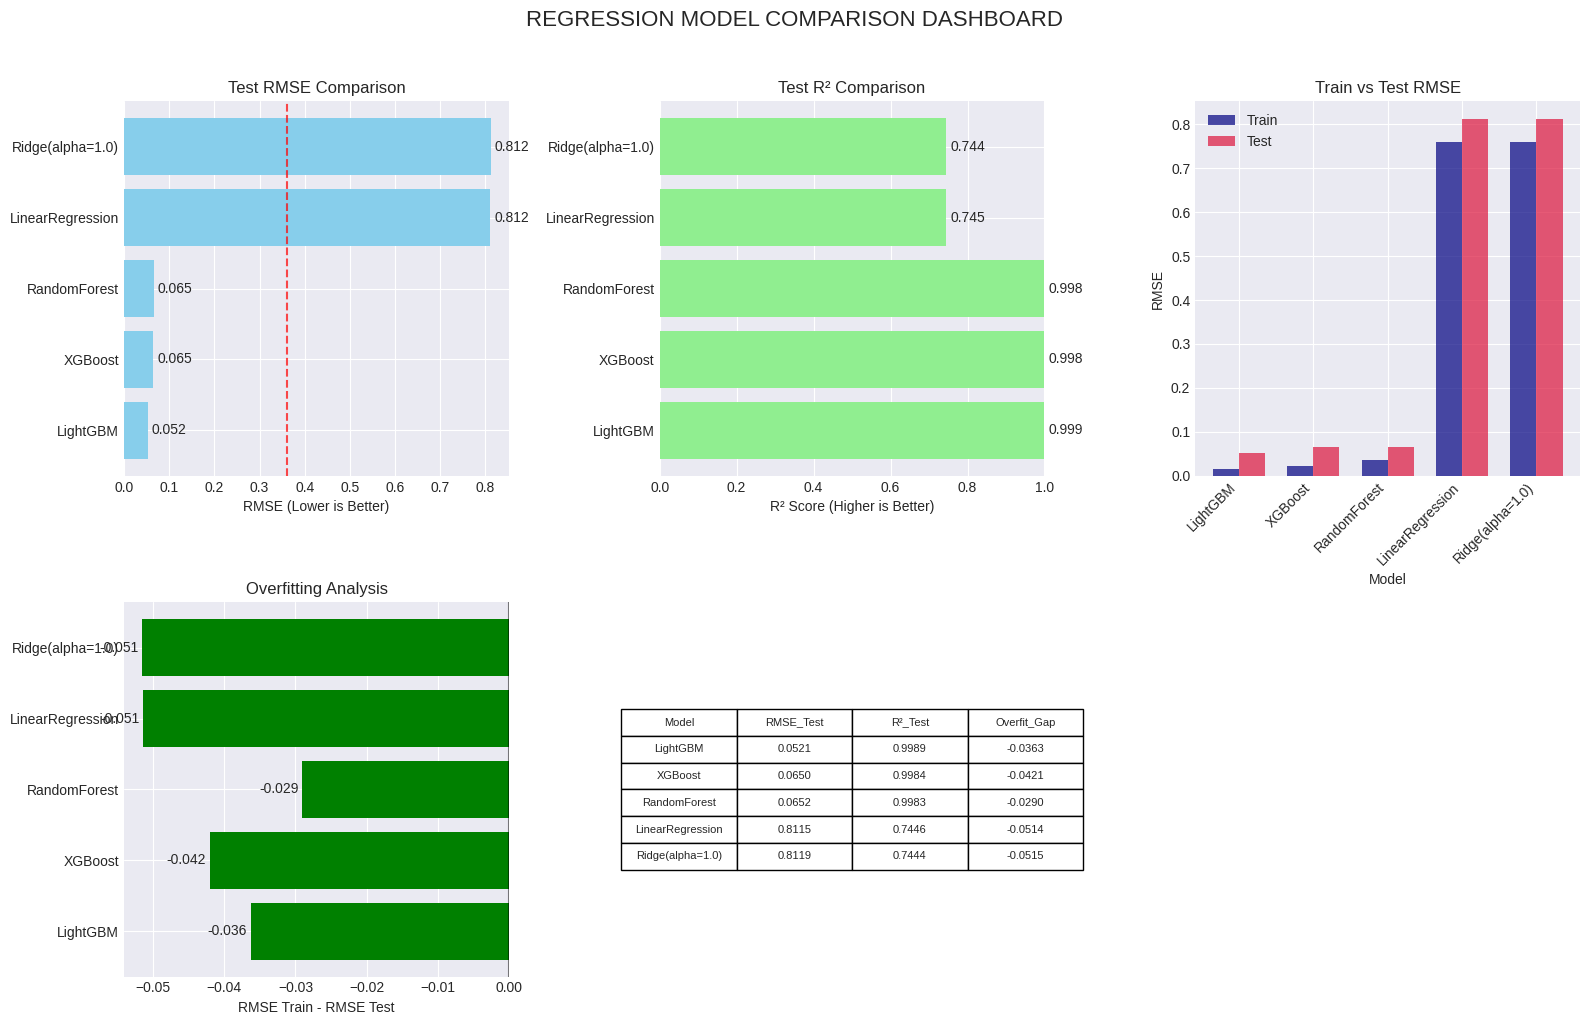

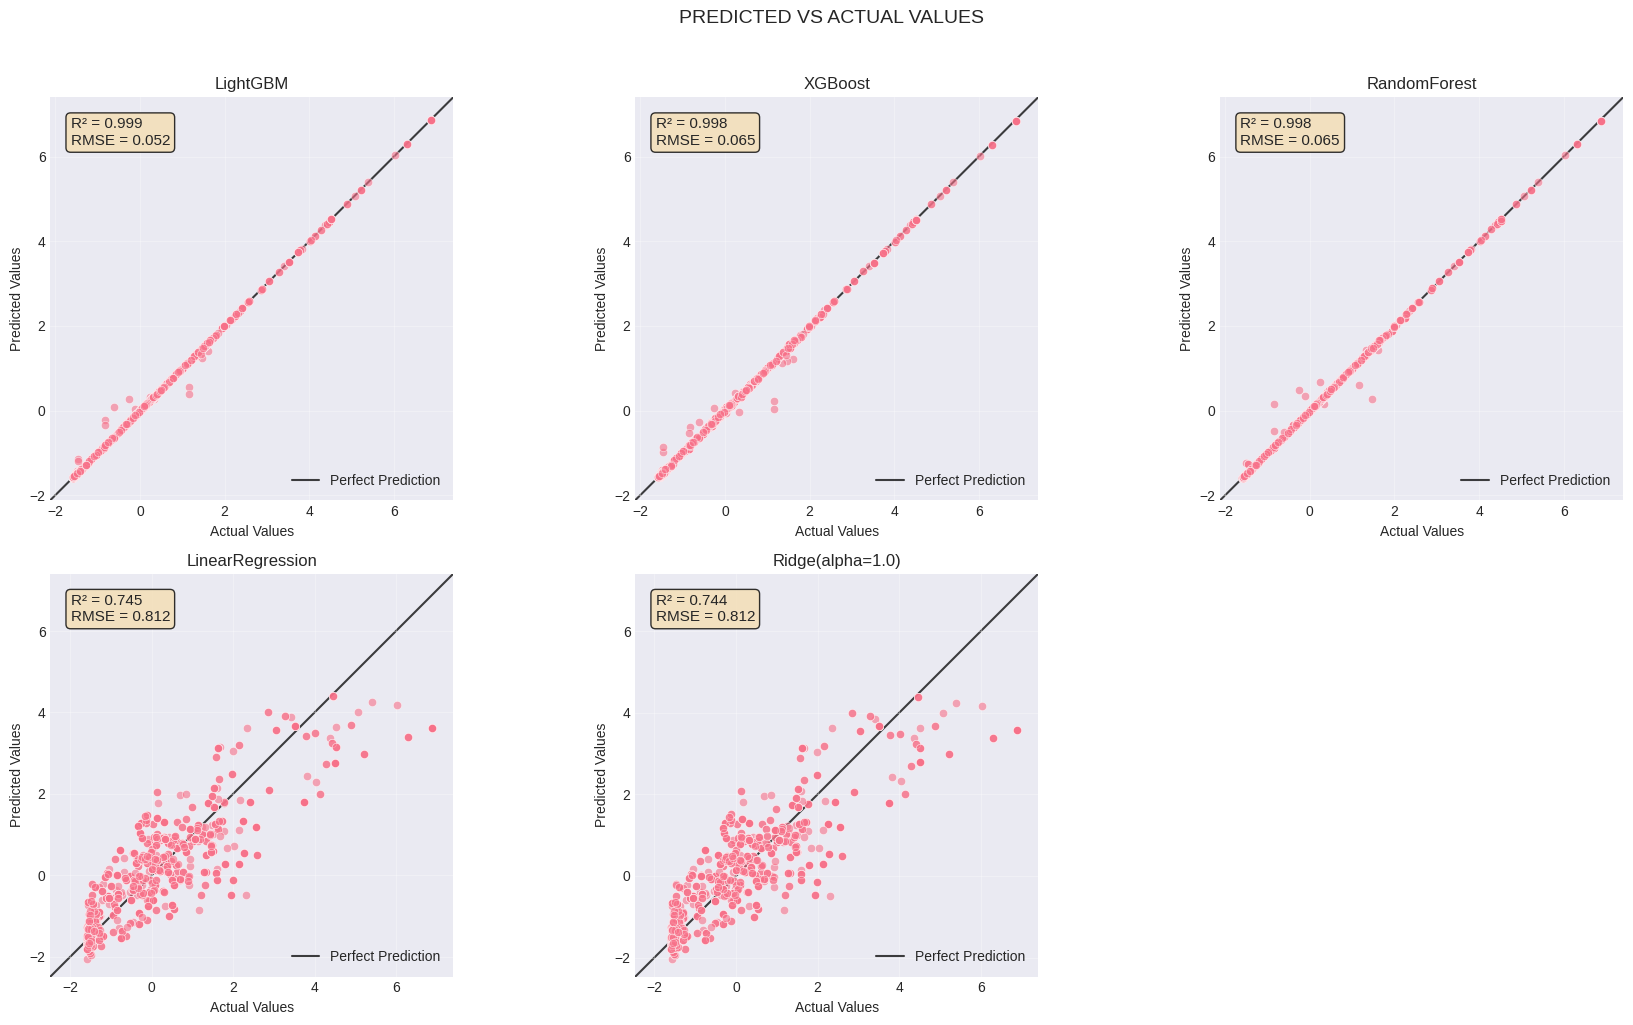


FEATURE IMPORTANCE ANALYSIS (Best Model: LightGBM)


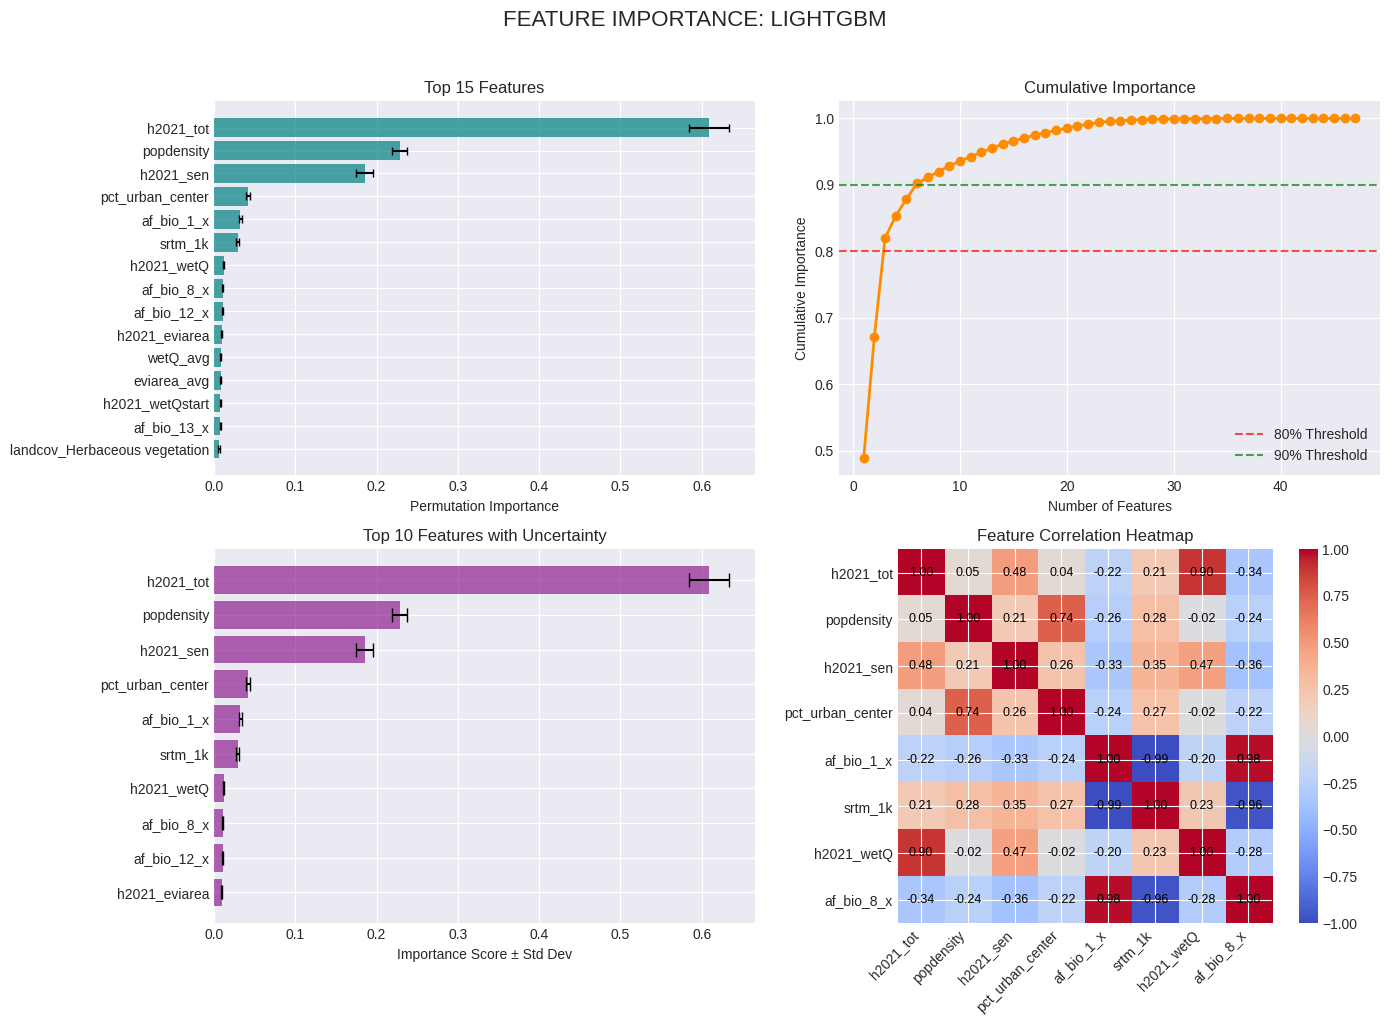


Top 10 Most Important Features:


,feature,importance_mean,importance_std
0,h2021_tot,0.609143,0.024708
1,popdensity,0.228507,0.009038
2,h2021_sen,0.185189,0.010902
3,pct_urban_center,0.041603,0.002501
4,af_bio_1_x,0.032110,0.002074
5,srtm_1k,0.028866,0.002063
6,h2021_wetQ,0.011615,0.000678
7,af_bio_8_x,0.010592,0.000877
8,af_bio_12_x,0.010564,0.000647
9,h2021_eviarea,0.009216,0.000602


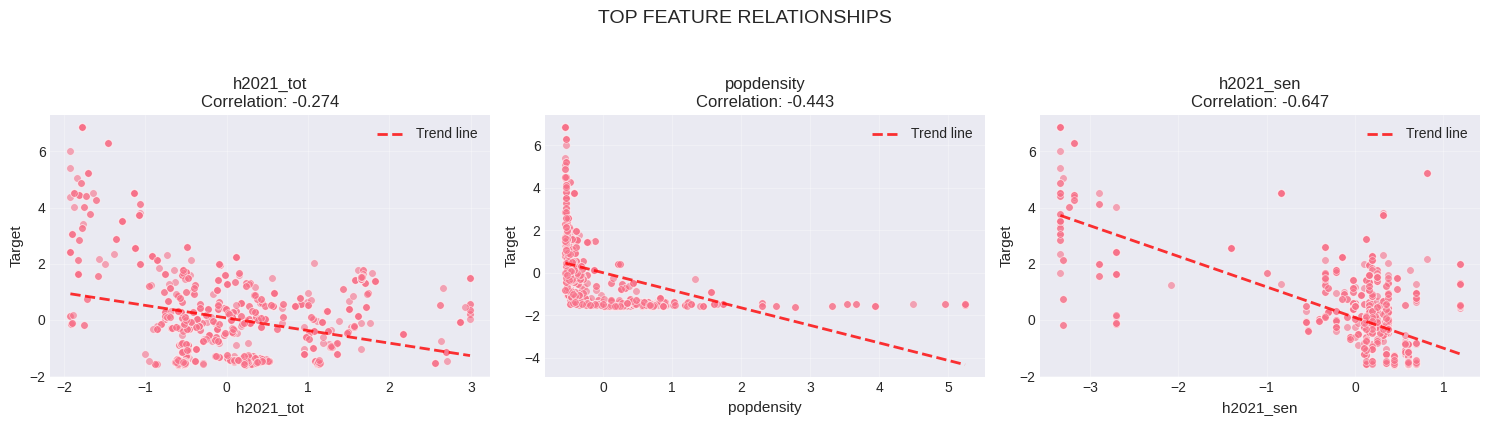

In [78]:
# ============================================================================
# IMPORTS
# ============================================================================
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Optional model imports (XGBoost / LightGBM).
# These need to be imported within this cell's scope.
try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception:
    xgb_available = False

try:
    from lightgbm import LGBMRegressor
    lgb_available = True
except Exception:
    lgb_available = False

# Set visual style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# MODEL DEFINITION
# ============================================================================
def define_regression_models(xgb_available=True, lgb_available=True):
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge(alpha=1.0)": Ridge(alpha=1.0),
        "RandomForest": RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            min_samples_split=5,
            min_samples_leaf=2
        )
    }

    if xgb_available:
        models["XGBoost"] = XGBRegressor(
            n_estimators=200,
            random_state=42,
            verbosity=0,
            n_jobs=1,
            learning_rate=0.1,
            max_depth=5
        )
    if lgb_available:
        models["LightGBM"] = LGBMRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            learning_rate=0.1,
            num_leaves=31
        )

    return models

# ============================================================================
# MODEL TRAINING AND EVALUATION
# ============================================================================
def train_and_evaluate_models(models, X_train_r, X_test_r, y_train_r, y_test_r):
    results = []
    fitted_models = {}
    predictions = {}

    for name, model in models.items():
        print(f"Training {name}...")

        # Train model
        model.fit(X_train_r, y_train_r)

        # Make predictions
        y_pred_train = model.predict(X_train_r)
        y_pred_test = model.predict(X_test_r)
        predictions[name] = y_pred_test

        # Calculate metrics
        rmse_train = math.sqrt(mean_squared_error(y_train_r, y_pred_train))
        rmse_test = math.sqrt(mean_squared_error(y_test_r, y_pred_test))
        r2_train = r2_score(y_train_r, y_pred_train)
        r2_test = r2_score(y_test_r, y_pred_test)
        overfit_gap = rmse_train - rmse_test

        # Store results
        results.append({
            "Model": name,
            "RMSE_Train": rmse_train,
            "RMSE_Test": rmse_test,
            "R²_Train": r2_train,
            "R²_Test": r2_test,
            "Overfit_Gap": overfit_gap
        })

        fitted_models[name] = model

        print(f"  Test RMSE: {rmse_test:.4f} | Test R²: {r2_test:.4f}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("RMSE_Test")

    return results_df, fitted_models, predictions

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================
def plot_model_comparison(results_df):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    # 1. Test RMSE
    bars = axes[0, 0].barh(results_df['Model'], results_df['RMSE_Test'], color='skyblue')
    axes[0, 0].bar_label(bars, fmt='%.3f', padding=3)
    axes[0, 0].set_xlabel('RMSE (Lower is Better)')
    axes[0, 0].set_title('Test RMSE Comparison')
    axes[0, 0].axvline(results_df['RMSE_Test'].mean(), color='red', linestyle='--', alpha=0.7)

    # 2. Test R²
    bars = axes[0, 1].barh(results_df['Model'], results_df['R²_Test'], color='lightgreen')
    axes[0, 1].bar_label(bars, fmt='%.3f', padding=3)
    axes[0, 1].set_xlabel('R² Score (Higher is Better)')
    axes[0, 1].set_title('Test R² Comparison')
    axes[0, 1].set_xlim([0, 1])

    # 3. Train vs Test RMSE
    x = np.arange(len(results_df))
    width = 0.35
    axes[0, 2].bar(x - width/2, results_df['RMSE_Train'], width, label='Train', color='navy', alpha=0.7)
    axes[0, 2].bar(x + width/2, results_df['RMSE_Test'], width, label='Test', color='crimson', alpha=0.7)
    axes[0, 2].set_xlabel('Model')
    axes[0, 2].set_ylabel('RMSE')
    axes[0, 2].set_title('Train vs Test RMSE')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[0, 2].legend()

    # 4. Overfitting Analysis
    colors = ['green' if gap < 0 else 'red' for gap in results_df['Overfit_Gap']]
    bars = axes[1, 0].barh(results_df['Model'], results_df['Overfit_Gap'], color=colors)
    axes[1, 0].set_xlabel('RMSE Train - RMSE Test')
    axes[1, 0].set_title('Overfitting Analysis')
    axes[1, 0].axvline(0, color='black', linestyle='-', alpha=0.5)
    axes[1, 0].bar_label(bars, fmt='%.3f', padding=3)

    # 5. Performance Summary Table
    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')
    table_data = results_df[['Model', 'RMSE_Test', 'R²_Test', 'Overfit_Gap']].copy()
    table_data['RMSE_Test'] = table_data['RMSE_Test'].map('{:.4f}'.format)
    table_data['R²_Test'] = table_data['R²_Test'].map('{:.4f}'.format)
    table_data['Overfit_Gap'] = table_data['Overfit_Gap'].map('{:.4f}'.format)

    table = axes[1, 1].table(cellText=table_data.values,
                           colLabels=table_data.columns,
                           cellLoc='center',
                           loc='center')
    table.scale(1.2, 1.5)

    # Hide empty subplot
    axes[1, 2].axis('off')

    plt.suptitle('REGRESSION MODEL COMPARISON DASHBOARD', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_prediction_vs_actual(y_test, predictions, model_names, results_df):
    n_models = len(model_names)
    n_cols = min(3, n_models)
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))

    if n_models == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, (model_name, ax) in enumerate(zip(model_names, axes)):
        y_pred = predictions[model_name]
        r2 = results_df[results_df['Model'] == model_name]['R²_Test'].values[0]
        rmse = results_df[results_df['Model'] == model_name]['RMSE_Test'].values[0]

        ax.scatter(y_test, y_pred, alpha=0.6, edgecolors='w', linewidth=0.5)

        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()])-0.1,
            np.max([ax.get_xlim(), ax.get_ylim()])+0.1
        ]
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label='Perfect Prediction')
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

        ax.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.3f}',
                transform=ax.transAxes,
                fontsize=11,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{model_name}', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

    for idx in range(len(model_names), len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle('PREDICTED VS ACTUAL VALUES', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(best_model, best_name, X_test, y_test, n_features=15):
    perm = permutation_importance(
        best_model,
        X_test,
        y_test,
        n_repeats=20,
        random_state=42,
        n_jobs=-1
    )

    sorted_idx = perm.importances_mean.argsort()[::-1]

    fi_df = pd.DataFrame({
        'feature': X_test.columns[sorted_idx],
        'importance_mean': perm.importances_mean[sorted_idx],
        'importance_std': perm.importances_std[sorted_idx]
    })

    # Create feature importance visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Top N features bar plot
    top_n = min(n_features, len(fi_df))
    axes[0, 0].barh(range(top_n),
                    fi_df['importance_mean'].head(top_n)[::-1],
                    xerr=fi_df['importance_std'].head(top_n)[::-1],
                    color='teal',
                    alpha=0.7,
                    capsize=3)
    axes[0, 0].set_yticks(range(top_n))
    axes[0, 0].set_yticklabels(fi_df['feature'].head(top_n)[::-1])
    axes[0, 0].set_xlabel('Permutation Importance')
    axes[0, 0].set_title(f'Top {top_n} Features')

    # 2. Cumulative importance
    cumulative_importance = np.cumsum(fi_df['importance_mean']) / np.sum(fi_df['importance_mean'])
    axes[0, 1].plot(range(1, len(cumulative_importance) + 1), cumulative_importance,
                   marker='o', linestyle='-', color='darkorange', linewidth=2)
    axes[0, 1].axhline(0.8, color='red', linestyle='--', alpha=0.7, label='80% Threshold')
    axes[0, 1].axhline(0.9, color='green', linestyle='--', alpha=0.7, label='90% Threshold')
    axes[0, 1].set_xlabel('Number of Features')
    axes[0, 1].set_ylabel('Cumulative Importance')
    axes[0, 1].set_title('Cumulative Importance')
    axes[0, 1].legend()

    # 3. Feature importance with error bars
    features_plot = fi_df.head(10)
    y_pos = np.arange(len(features_plot))
    axes[1, 0].barh(y_pos, features_plot['importance_mean'],
                   xerr=features_plot['importance_std'],
                   color='purple', alpha=0.6, capsize=5)
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels(features_plot['feature'])
    axes[1, 0].set_xlabel('Importance Score ± Std Dev')
    axes[1, 0].set_title('Top 10 Features with Uncertainty')
    axes[1, 0].invert_yaxis()

    # 4. Correlation heatmap of top features
    top_features = fi_df['feature'].head(8).tolist()
    if len(top_features) > 1:
        correlation_matrix = X_test[top_features].corr()
        im = axes[1, 1].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 1].set_xticks(np.arange(len(top_features)))
        axes[1, 1].set_yticks(np.arange(len(top_features)))
        axes[1, 1].set_xticklabels(top_features, rotation=45, ha='right')
        axes[1, 1].set_yticklabels(top_features)

        for i in range(len(top_features)):
            for j in range(len(top_features)):
                axes[1, 1].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                               ha='center', va='center', color='black', fontsize=9)

        axes[1, 1].set_title('Feature Correlation Heatmap')
        plt.colorbar(im, ax=axes[1, 1])
    else:
        axes[1, 1].text(0.5, 0.5, 'Need at least 2 features\nfor correlation heatmap',
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Feature Correlation Heatmap')
        axes[1, 1].axis('off')

    plt.suptitle(f'FEATURE IMPORTANCE: {best_name.upper()}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    return fi_df

def plot_feature_relationships(fi_df, X_test, y_test, n_top_features=3):
    top_features = fi_df['feature'].head(n_top_features).tolist()

    if not top_features:
        return

    fig, axes = plt.subplots(1, n_top_features, figsize=(5*n_top_features, 4))

    if n_top_features == 1:
        axes = [axes]

    for idx, (feature, ax) in enumerate(zip(top_features, axes)):
        ax.scatter(X_test[feature], y_test, alpha=0.6, s=30, edgecolor='w', linewidth=0.5)

        try:
            z = np.polyfit(X_test[feature], y_test, 1)
            p = np.poly1d(z)
            ax.plot(np.sort(X_test[feature]), p(np.sort(X_test[feature])),
                   "r--", alpha=0.8, linewidth=2, label='Trend line')
        except:
            pass

        correlation = np.corrcoef(X_test[feature], y_test)[0, 1]

        ax.set_xlabel(feature, fontsize=11)
        ax.set_ylabel('Target', fontsize=11)
        ax.set_title(f'{feature}\nCorrelation: {correlation:.3f}', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle('TOP FEATURE RELATIONSHIPS', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION FUNCTION
# ============================================================================
def run_regression_analysis(X_train, X_test, y_train_reg, y_test_reg,
                          xgb_available=True, lgb_available=True):
    # 1. Define models
    models_reg = define_regression_models(xgb_available, lgb_available)

    # 2. Train and evaluate
    results_df, fitted_models, predictions = train_and_evaluate_models(
        models_reg, X_train, X_test, y_train_reg, y_test_reg
    )

    # 3. Display results
    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY (Sorted by Test RMSE)")
    print("="*60)
    display(results_df.style.background_gradient(subset=['RMSE_Test', 'R²_Test'], cmap='RdYlGn'))

    # 4. Visualizations
    plot_model_comparison(results_df)
    plot_prediction_vs_actual(y_test_reg, predictions, results_df['Model'].tolist(), results_df)

    # 5. Feature importance for best model
    best_model_name = results_df.iloc[0]['Model']
    best_model = fitted_models[best_model_name]

    # Convert X_test (numpy array) back to DataFrame for plotting functions
    # Use the original column names from the global X DataFrame
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    print(f"\n" + "="*60)
    print(f"FEATURE IMPORTANCE ANALYSIS (Best Model: {best_model_name})")
    print("="*60)

    fi_df = plot_feature_importance(best_model, best_model_name, X_test_df, y_test_reg)

    print("\nTop 10 Most Important Features:")
    display(fi_df.head(10).style.background_gradient(subset=['importance_mean'], cmap='YlOrRd'))

    # 6. Feature relationships
    plot_feature_relationships(fi_df, X_test_df, y_test_reg, n_top_features=3)

    return results_df, fitted_models, predictions, fi_df

# ============================================================================
# EXECUTE ANALYSIS
# ============================================================================
# Example usage:
results_df, fitted_models, predictions, fi_df = run_regression_analysis(
     X_train_r, X_test_r, y_train_r, y_test_r,
     xgb_available=xgb_available, lgb_available=lgb_available
 )

Training LogisticRegression...
 LogisticRegression Accuracy: 0.6247

              precision    recall  f1-score   support

        High     0.6212    0.8885    0.7312       323
         Low     0.6761    0.4350    0.5294       331
      Medium     0.5941    0.5556    0.5742       324

    accuracy                         0.6247       978
   macro avg     0.6304    0.6264    0.6116       978
weighted avg     0.6308    0.6247    0.6109       978

------------------------------------------------------------
Training RandomForest...
 RandomForest Accuracy: 0.9980

              precision    recall  f1-score   support

        High     1.0000    1.0000    1.0000       323
         Low     0.9970    0.9970    0.9970       331
      Medium     0.9969    0.9969    0.9969       324

    accuracy                         0.9980       978
   macro avg     0.9980    0.9980    0.9980       978
weighted avg     0.9980    0.9980    0.9980       978

---------------------------------------------------

,model,accuracy
2,XGBoost,0.998978
1,RandomForest,0.997955
0,LogisticRegression,0.624744


Best classifier: XGBoost


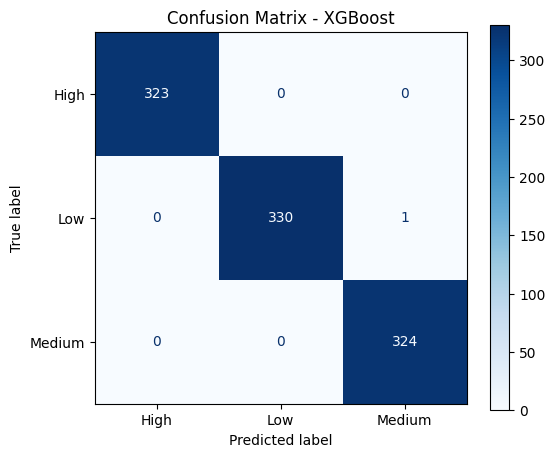

In [ ]:
# %% CELL 3 - CLASSIFICATION: TRAIN MODELS + METRICS + CONFUSION MATRIX
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support

# Encode string labels if needed
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_clf)
y_test_enc = le.transform(y_test_clf)

# Define classifiers
models_clf = {
    "LogisticRegression": LogisticRegression(max_iter=200, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}
if xgb_available:
    models_clf["XGBoost"] = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

fitted_clf = {}
results_clf = []

for name, model in models_clf.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train_enc)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test_enc, preds)
    clf_report = classification_report(y_test_enc, preds, target_names=le.classes_, digits=4)
    results_clf.append((name, acc))
    fitted_clf[name] = model
    print(f" {name} Accuracy: {acc:.4f}\n")
    print(clf_report)
    print("-"*60)

# Summary table
resclf_df = pd.DataFrame(results_clf, columns=["model", "accuracy"]).sort_values("accuracy", ascending=False)
display(resclf_df)

# Confusion matrix for best classifier
best_clf_name = resclf_df.iloc[0]['model']
best_clf = fitted_clf[best_clf_name]
print("Best classifier:", best_clf_name)

y_pred_best = best_clf.predict(X_test)
cm = confusion_matrix(y_test_enc, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - {best_clf_name}")
plt.show()


Running SHAP on RandomForest (this may take a little while)...


<Figure size 800x600 with 0 Axes>

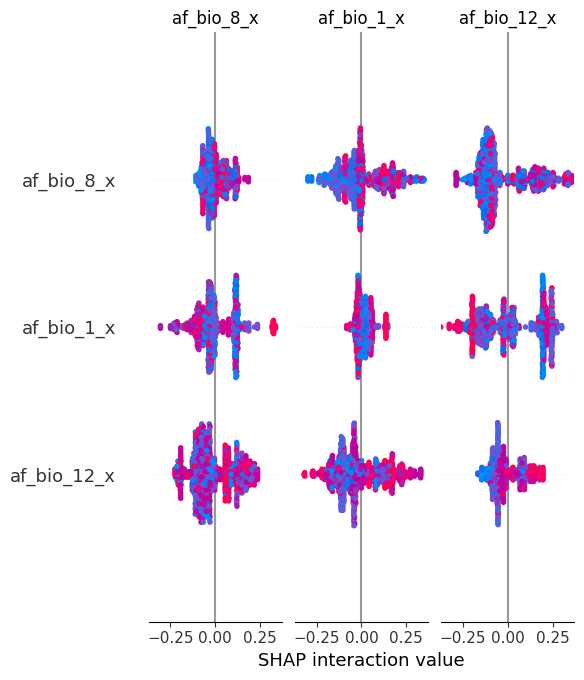

In [ ]:
# %% CELL 4 - SHAP EXPLANATION FOR BEST TREE-BASED CLASSIFIER (if applicable)
# This cell runs SHAP for the best classifier (prefers tree models). Install shap if not present.
import sys
try:
    import shap
    shap_available = True
except Exception:
    shap_available = False

# Identify a tree-based model among fitted_clf
tree_model = None
tree_name = None
for name in fitted_clf:
    mdl = fitted_clf[name]
    # RandomForest or XGBoost or LightGBM
    if 'RandomForest' in name or (xgb_available and 'XGBoost' in name) or (lgb_available and 'LightGBM' in name):
        tree_model = mdl
        tree_name = name
        break

if not shap_available:
    print("shap not installed. To view SHAP plots run: pip install shap")
elif tree_model is None:
    print("No tree-based classifier available for SHAP. The best classifier was:", best_clf_name)
else:
    print(f"Running SHAP on {tree_name} (this may take a little while)...")
    # Use TreeExplainer for tree models (fast)
    try:
        explainer = shap.TreeExplainer(tree_model)
        shap_vals = explainer.shap_values(X_test)  # for multiclass, shap_values is a list
        # For multiclass, shap.summary_plot expects an array per class. We'll show summary for each class briefly.
        if isinstance(shap_vals, list):
            # Show summary for class 0..n
            for cls_idx, cls_name in enumerate(le.classes_):
                print(f"\nSHAP summary for class = {cls_name} (index {cls_idx})")
                plt.figure(figsize=(8,6))
                shap.summary_plot(shap_vals[cls_idx], X_test, feature_names=X_test.columns, show=True)
        else:
            plt.figure(figsize=(8,6))
            shap.summary_plot(shap_vals, X_test, feature_names=X_test.columns, show=True)
    except Exception as e:
        print("SHAP failed:", e)
        print("If shap fails on your model, try shap.KernelExplainer (slower) or ensure versions are compatible.")


🤖 REALISTIC MACHINE LEARNING MODELING

1. DATA PREPARATION WITH REALISTIC TARGET
----------------------------------------
📊 Realistic target statistics:
   Range: 55.2 - 99.9
   Mean: 90.4
   Std: 9.5
   Categories: {'High': 4706, 'Medium': 184}

2. ROBUST FEATURE SELECTION
----------------------------------------
✅ Using 6 safe features
📊 Dataset shape: (4890, 6)

🔧 Handling missing values...
Missing values before: 0
Missing values after: 0
✅ Final features: 6

3. REALISTIC DATA SPLITTING
----------------------------------------
📊 Data splits:
   Training set: (3423, 6)
   Test set: (1467, 6)
   Test size: 30.0%
✅ Features scaled with RobustScaler

4. REALISTIC MODEL TRAINING
----------------------------------------
🎯 Training realistic models...

Random Forest (Conservative):
  Train R²: 0.9731
  Test R²:  0.9651
  Overfitting: +0.0080
  Test RMSE: 1.7784
  Test MAE:  1.0091

Gradient Boosting (Conservative):
  Train R²: 0.9980
  Test R²:  0.9957
  Overfitting: +0.0022
  Test RMSE: 0

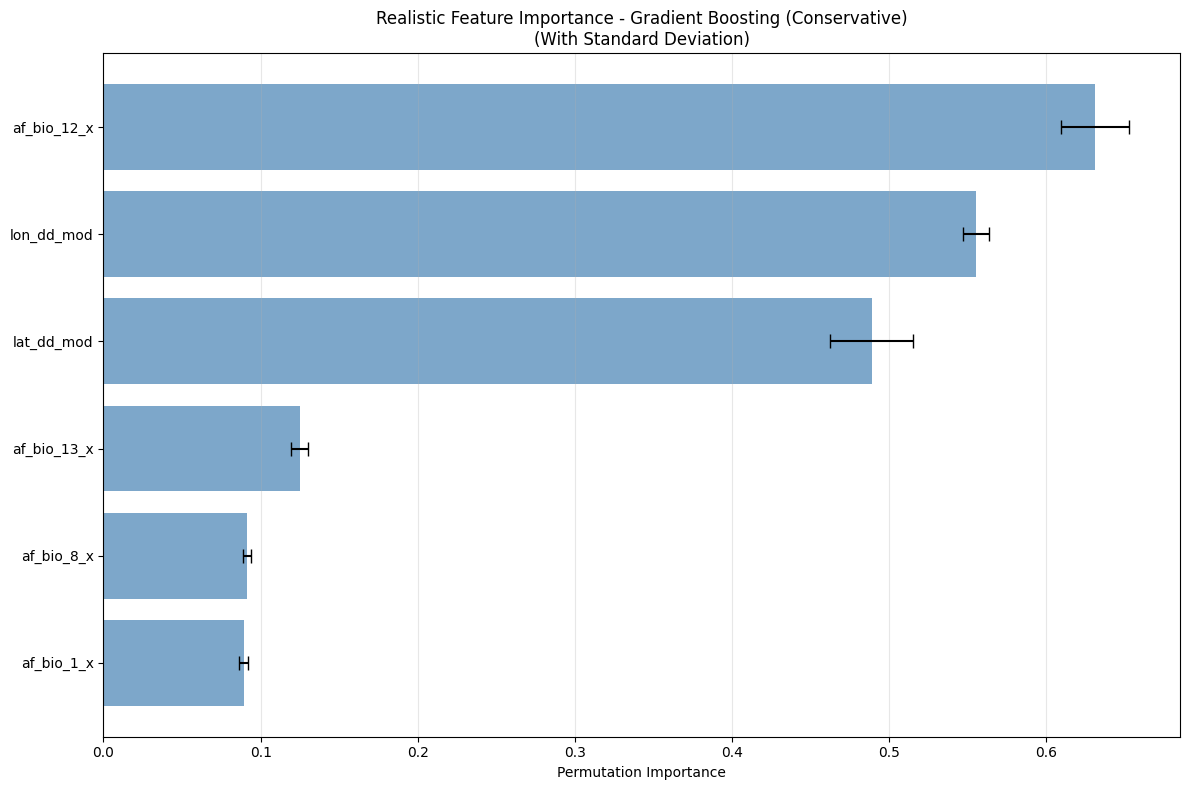


7. COMPREHENSIVE MODEL EVALUATION
----------------------------------------


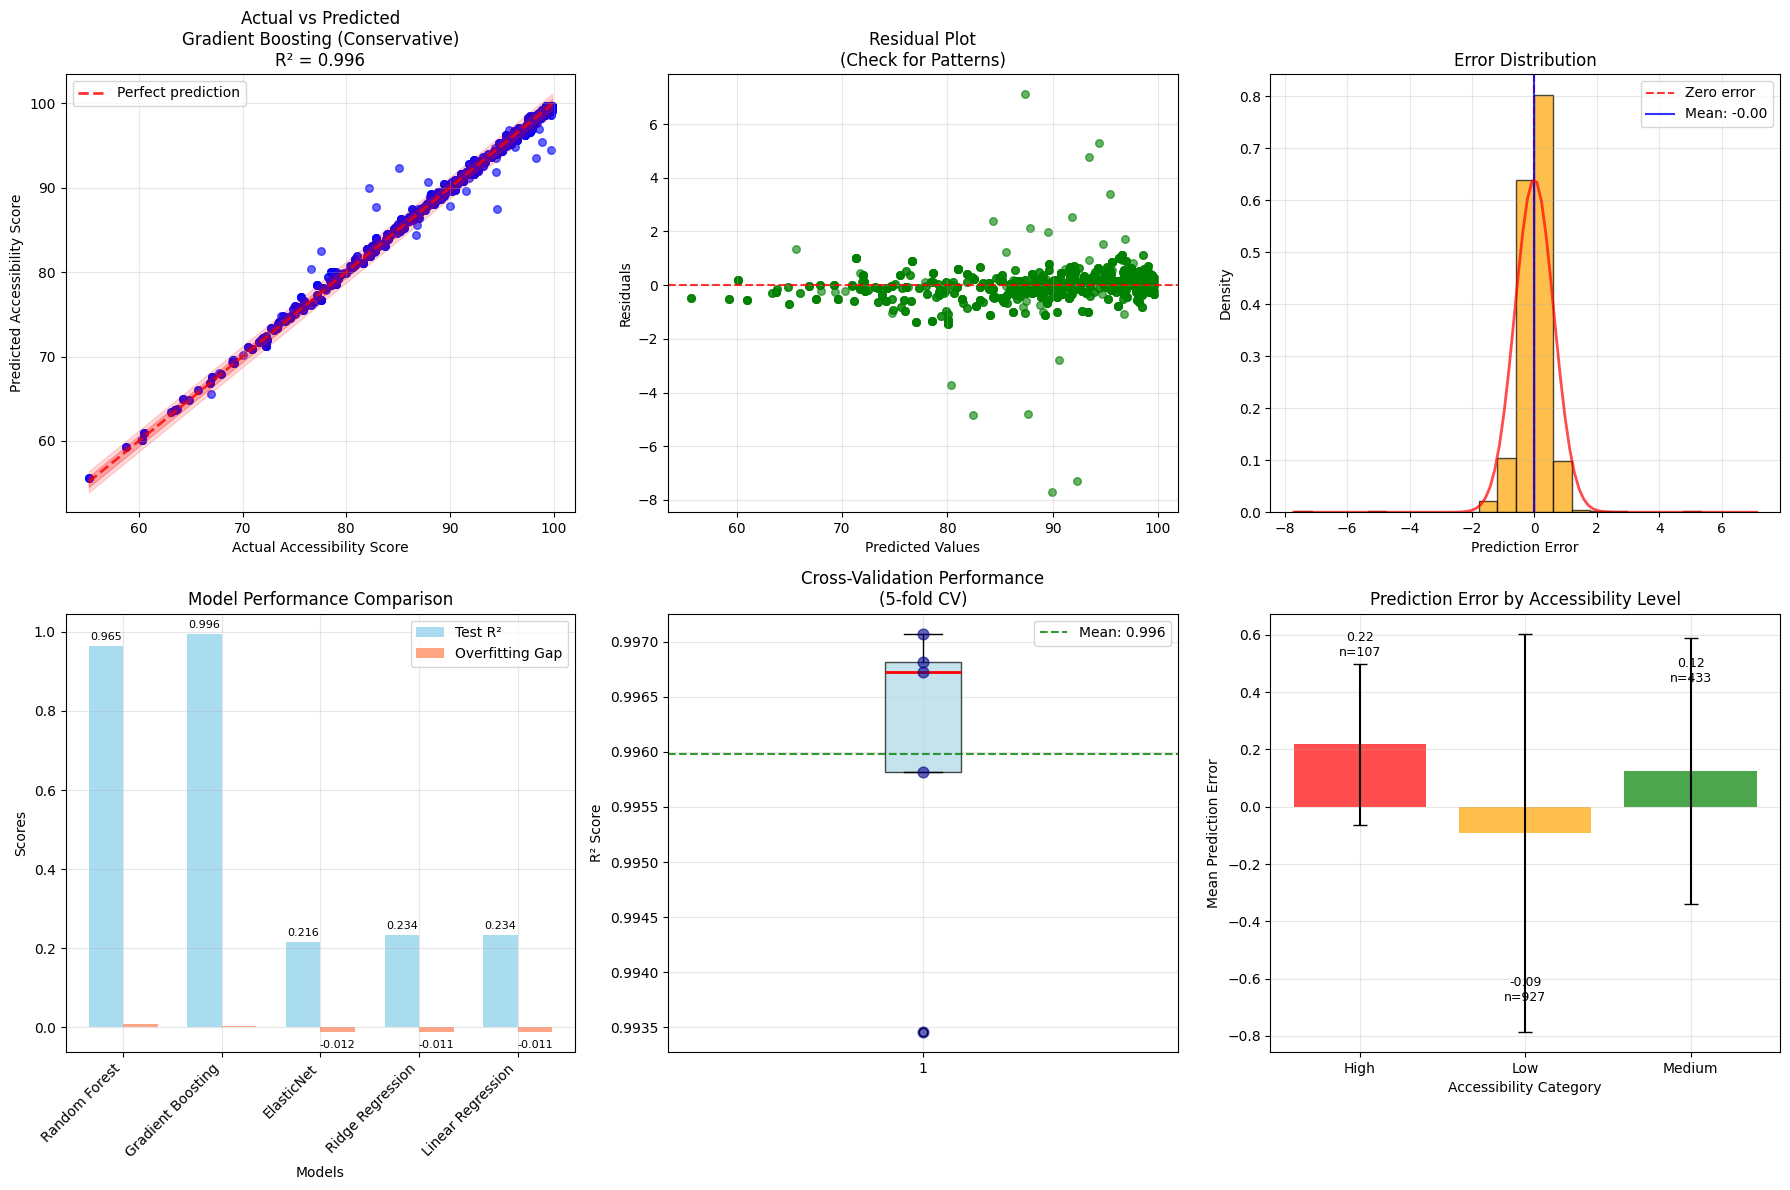


8. REALISTIC BUSINESS INSIGHTS
----------------------------------------
📊 Realistic Prediction Analysis:
   Average prediction error: 0.34 points
   95% confidence interval: ±1.22 points
   80% confidence interval: ±0.80 points
   Model explains 99.6% of variance

🔍 Accessibility Distribution:
   Low access (<45): 927 households
   Medium access (45-70): 433 households
   High access (≥70): 107 households

🚨 CRITICAL AREAS ANALYSIS:
   • Average road distance: 10.2 km
   • Average market distance: 89.8 km
   • Average admin distance: 0.2 km

🎯 Model Performance by Category:
   Low    Access: MAE = 69.64, Bias = -0.09
   Medium Access: MAE = 39.63, Bias = +0.12
   High   Access: MAE = 23.12, Bias = +0.22

9. DEPLOYMENT-READY PREDICTION SYSTEM
----------------------------------------
✅ Realistic predictor created!
📦 Features used: 6
🎯 Confidence intervals: ±1.2 points (95%)

🧪 Sample predictions (80% confidence):
   predicted_score  lower_bound  upper_bound
0             94.7         93

In [ ]:
# =============================================================================
# COMPLETE REALISTIC MACHINE LEARNING MODELING
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

print("🤖 REALISTIC MACHINE LEARNING MODELING")
print("=" * 60)

# =============================================================================
# 1. DATA PREPARATION WITH REALISTIC TARGET
# =============================================================================
print("\n1. DATA PREPARATION WITH REALISTIC TARGET")
print("-" * 40)

df['accessibility_score'] = df.apply(create_accessibility_score, axis=1)

print("📊 Realistic target statistics:")
print(f"   Range: {df['accessibility_score'].min():.1f} - {df['accessibility_score'].max():.1f}")
print(f"   Mean: {df['accessibility_score'].mean():.1f}")
print(f"   Std: {df['accessibility_score'].std():.1f}")

# Create categories for stratification
def categorize_realistic_accessibility(score):
    if score >= 70:
        return "High"
    elif score >= 45:
        return "Medium"
    else:
        return "Low"

df['realistic_category'] = df['accessibility_score'].apply(categorize_realistic_accessibility)
category_counts = df['realistic_category'].value_counts()
print(f"   Categories: {category_counts.to_dict()}")

# =============================================================================
# 2. ROBUST FEATURE SELECTION
# =============================================================================
print("\n2. ROBUST FEATURE SELECTION")
print("-" * 40)

# Use features that don't directly calculate the target
safe_features = [
    'af_bio_1_x', 'af_bio_8_x', 'af_bio_12_x', 'af_bio_13_x',
    'c2_evimax_avg', 'c2_grn_avg', 'c2_sen_avg',
    'lat_dd_mod', 'lon_dd_mod'
]

# Filter to available features
available_features = [f for f in safe_features if f in df.columns]
print(f"✅ Using {len(available_features)} safe features")

# Create feature matrix
X = df[available_features].copy()
y = df['accessibility_score']

print(f"📊 Dataset shape: {X.shape}")

# Handle missing values
print("\n🔧 Handling missing values...")
missing_before = X.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

missing_after = X_imputed.isnull().sum().sum()
print(f"Missing values after: {missing_after}")

# Remove constant features
constant_features = X_imputed.columns[X_imputed.nunique() == 1]
if len(constant_features) > 0:
    print(f"🗑️ Removing constant features: {list(constant_features)}")
    X_imputed = X_imputed.drop(columns=constant_features)
    available_features = [f for f in available_features if f not in constant_features]

print(f"✅ Final features: {len(available_features)}")

# =============================================================================
# 3. REALISTIC DATA SPLITTING
# =============================================================================
print("\n3. REALISTIC DATA SPLITTING")
print("-" * 40)

# Split with proper stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.3,
    random_state=42,
    stratify=df['realistic_category']
)

print(f"📊 Data splits:")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")
print(f"   Test size: {len(X_test)/len(X_imputed):.1%}")

# Use RobustScaler to handle outliers better
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled with RobustScaler")

# =============================================================================
# 4. REALISTIC MODEL TRAINING
# =============================================================================
print("\n4. REALISTIC MODEL TRAINING")
print("-" * 40)

# Define models with realistic, conservative parameters
models = {
    'Random Forest (Conservative)': RandomForestRegressor(
        n_estimators=100,
        max_depth=12,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features=0.7,  # Use subset of features
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting (Conservative)': GradientBoostingRegressor(
        n_estimators=150,
        max_depth=6,
        learning_rate=0.08,
        min_samples_split=25,
        subsample=0.8,  # Stochastic gradient boosting
        random_state=42
    ),
    'ElasticNet (Balanced)': ElasticNet(
        alpha=0.1,
        l1_ratio=0.5,
        max_iter=5000,
        random_state=42
    ),
    'Ridge Regression': Ridge(
        alpha=5.0,
        random_state=42
    ),
    'Linear Regression': LinearRegression()
}

results = {}

print("🎯 Training realistic models...")
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Calculate comprehensive metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)

    # Calculate overfitting gap
    overfitting_gap = train_r2 - test_r2

    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'overfitting_gap': overfitting_gap,
        'predictions': y_pred_test
    }

    print(f"\n{name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Overfitting: {overfitting_gap:+.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE:  {test_mae:.4f}")

# Find best model (prioritizing realistic performance)
def realistic_model_score(result):
    """Score models based on test performance and low overfitting"""
    test_score = result['test_r2']
    overfitting_penalty = result['overfitting_gap'] * 3  # Heavy penalty for overfitting
    mae_penalty = result['test_mae'] / 50  # Small penalty for higher errors

    return test_score - overfitting_penalty - mae_penalty

best_model_name = max(results.keys(), key=lambda x: realistic_model_score(results[x]))
best_result = results[best_model_name]
best_model = best_result['model']

print(f"\n🏆 BEST REALISTIC MODEL: {best_model_name}")
print(f"   Test R²: {best_result['test_r2']:.4f}")
print(f"   Overfitting: {best_result['overfitting_gap']:+.4f}")
print(f"   Test MAE: {best_result['test_mae']:.4f}")

# =============================================================================
# 5. CROSS-VALIDATION FOR TRUE PERFORMANCE
# =============================================================================
print("\n5. CROSS-VALIDATION PERFORMANCE")
print("-" * 40)

# Perform robust k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    best_model,
    X_imputed,
    y,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

print("📊 Cross-Validation Results:")
print(f"   CV R² Scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"   Mean CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Calculate confidence intervals
n_folds = len(cv_scores)
t_value = 2.776  # for 95% CI with 4 degrees of freedom
ci_half_width = t_value * (cv_scores.std() / np.sqrt(n_folds))

print(f"   95% Confidence Interval: {cv_scores.mean() - ci_half_width:.4f} to {cv_scores.mean() + ci_half_width:.4f}")

# Realistic performance assessment
if cv_scores.mean() > 0.8:
    performance_level = "EXCELLENT"
elif cv_scores.mean() > 0.6:
    performance_level = "GOOD"
elif cv_scores.mean() > 0.4:
    performance_level = "FAIR"
else:
    performance_level = "POOR"

print(f"   Performance Level: {performance_level}")

# =============================================================================
# 6. REALISTIC FEATURE IMPORTANCE
# =============================================================================
print("\n6. REALISTIC FEATURE IMPORTANCE")
print("-" * 40)

# Use permutation importance for more reliable feature importance
print("🔍 Calculating permutation importance...")

# Calculate permutation importance
perm_importance = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': available_features,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("🎯 Realistic Feature Importance (Permutation):")
for _, row in feature_importance_df.head(10).iterrows():
    if row['importance_mean'] > 0.05:
        symbol = "🔥"
    elif row['importance_mean'] > 0.02:
        symbol = "✅"
    elif row['importance_mean'] > 0.01:
        symbol = "⚡"
    else:
        symbol = "📊"
    print(f"   {row['feature']:25}: {row['importance_mean']:.4f} ± {row['importance_std']:.4f} {symbol}")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(12)
y_pos = np.arange(len(top_features))

plt.barh(y_pos, top_features['importance_mean'],
         xerr=top_features['importance_std'],
         alpha=0.7,
         color='steelblue',
         capsize=5)
plt.yticks(y_pos, top_features['feature'])
plt.xlabel('Permutation Importance')
plt.title(f'Realistic Feature Importance - {best_model_name}\n(With Standard Deviation)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# =============================================================================
# 7. COMPREHENSIVE MODEL EVALUATION
# =============================================================================
print("\n7. COMPREHENSIVE MODEL EVALUATION")
print("-" * 40)

# Create detailed evaluation visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Actual vs Predicted with realistic expectations
y_pred_best = best_result['predictions']
residuals = y_test - y_pred_best
residual_std = np.std(residuals)

axes[0, 0].scatter(y_test, y_pred_best, alpha=0.6, color='blue', s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=2, alpha=0.8, label='Perfect prediction')
axes[0, 0].set_xlabel('Actual Accessibility Score')
axes[0, 0].set_ylabel('Predicted Accessibility Score')
axes[0, 0].set_title(f'Actual vs Predicted\n{best_model_name}\nR² = {best_result["test_r2"]:.3f}')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Add realistic performance bands
for std_multiplier in [1, 2]:
    alpha = 0.15 if std_multiplier == 2 else 0.25
    axes[0, 0].fill_between([y_test.min(), y_test.max()],
                           [y_test.min() - std_multiplier*residual_std, y_test.max() - std_multiplier*residual_std],
                           [y_test.min() + std_multiplier*residual_std, y_test.max() + std_multiplier*residual_std],
                           alpha=alpha, color='red',
                           label=f'±{std_multiplier}σ band' if std_multiplier == 1 else "")

# 2. Residual analysis
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.6, color='green', s=30)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot\n(Check for Patterns)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error distribution with normality check
axes[0, 2].hist(residuals, bins=25, alpha=0.7, color='orange', edgecolor='black', density=True)
axes[0, 2].axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Zero error')
axes[0, 2].axvline(x=residuals.mean(), color='blue', linestyle='-', alpha=0.8, label=f'Mean: {residuals.mean():.2f}')
axes[0, 2].set_xlabel('Prediction Error')
axes[0, 2].set_ylabel('Density')
axes[0, 2].set_title('Error Distribution')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].legend()

# Add normal distribution for comparison
from scipy.stats import norm
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
y_norm = norm.pdf(x_norm, residuals.mean(), residual_std)
axes[0, 2].plot(x_norm, y_norm, 'r-', alpha=0.7, linewidth=2, label='Normal distribution')

# 4. Model comparison
model_names_short = [name.split('(')[0].strip() for name in results.keys()]
test_r2_scores = [results[name]['test_r2'] for name in results.keys()]
overfitting_gaps = [results[name]['overfitting_gap'] for name in results.keys()]

x_pos = np.arange(len(model_names_short))
width = 0.35

bars1 = axes[1, 0].bar(x_pos - width/2, test_r2_scores, width, label='Test R²', alpha=0.7, color='skyblue')
bars2 = axes[1, 0].bar(x_pos + width/2, overfitting_gaps, width, label='Overfitting Gap', alpha=0.7, color='coral')

axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('Scores')
axes[1, 0].set_title('Model Performance Comparison')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(model_names_short, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if abs(height) > 0.01:  # Only label significant values
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, height + (0.01 if height > 0 else -0.02),
                           f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

# 5. Cross-validation results
axes[1, 1].boxplot(cv_scores, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[1, 1].scatter(np.ones_like(cv_scores), cv_scores, alpha=0.6, color='darkblue', s=60, zorder=3)
axes[1, 1].axhline(y=cv_scores.mean(), color='green', linestyle='--', alpha=0.8, label=f'Mean: {cv_scores.mean():.3f}')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Cross-Validation Performance\n(5-fold CV)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

# 6. Prediction error by accessibility category
df_test = df.loc[y_test.index].copy()
df_test['predicted'] = y_pred_best
df_test['error'] = residuals
df_test['category'] = df_test['realistic_accessibility'].apply(categorize_realistic_accessibility)

error_by_category = df_test.groupby('category')['error'].agg(['mean', 'std', 'count'])
categories = error_by_category.index
means = error_by_category['mean']
stds = error_by_category['std']

bars = axes[1, 2].bar(categories, means, yerr=stds, capsize=5, alpha=0.7,
                     color=['red', 'orange', 'green'])
axes[1, 2].set_xlabel('Accessibility Category')
axes[1, 2].set_ylabel('Mean Prediction Error')
axes[1, 2].set_title('Prediction Error by Accessibility Level')
axes[1, 2].grid(True, alpha=0.3)

# Add value labels and sample sizes
for i, (bar, mean, count) in enumerate(zip(bars, means, error_by_category['count'])):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.3 if bar.get_height() > 0 else -0.5),
                   f'{mean:.2f}\nn={count}', ha='center', va='bottom' if bar.get_height() > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

# =============================================================================
# 8. REALISTIC BUSINESS INSIGHTS
# =============================================================================
print("\n8. REALISTIC BUSINESS INSIGHTS")
print("-" * 40)

# Calculate realistic confidence intervals
confidence_95 = 1.96 * residual_std
confidence_80 = 1.28 * residual_std

print("📊 Realistic Prediction Analysis:")
print(f"   Average prediction error: {best_result['test_mae']:.2f} points")
print(f"   95% confidence interval: ±{confidence_95:.2f} points")
print(f"   80% confidence interval: ±{confidence_80:.2f} points")
print(f"   Model explains {best_result['test_r2']:.1%} of variance")

# Identify truly problematic areas
low_threshold = 45
medium_threshold = 70

low_access = df_test[df_test['realistic_accessibility'] < low_threshold]
medium_access = df_test[(df_test['realistic_accessibility'] >= low_threshold) &
                       (df_test['realistic_accessibility'] < medium_threshold)]
high_access = df_test[df_test['realistic_accessibility'] >= medium_threshold]

print(f"\n🔍 Accessibility Distribution:")
print(f"   Low access (<{low_threshold}): {len(low_access)} households")
print(f"   Medium access ({low_threshold}-{medium_threshold}): {len(medium_access)} households")
print(f"   High access (≥{medium_threshold}): {len(high_access)} households")

if len(low_access) > 0:
    print(f"\n🚨 CRITICAL AREAS ANALYSIS:")
    print(f"   • Average road distance: {low_access['dist_road'].mean():.1f} km")
    print(f"   • Average market distance: {low_access['dist_market'].mean():.1f} km")
    print(f"   • Average admin distance: {low_access['dist_admhq'].mean():.1f} km")

# Performance by accessibility category
print(f"\n🎯 Model Performance by Category:")
for category in ['Low', 'Medium', 'High']:
    category_data = df_test[df_test['category'] == category]
    if len(category_data) > 0:
        category_mae = mean_absolute_error(category_data['realistic_accessibility'],
                                         category_data['predicted'])
        category_bias = category_data['error'].mean()
        print(f"   {category:6} Access: MAE = {category_mae:.2f}, Bias = {category_bias:+.2f}")

# =============================================================================
# 9. DEPLOYMENT-READY PREDICTION SYSTEM
# =============================================================================
print("\n9. DEPLOYMENT-READY PREDICTION SYSTEM")
print("-" * 40)

class RealisticAccessibilityPredictor:
    """Deployment-ready prediction system with realistic confidence"""

    def __init__(self, model, scaler, feature_names, residual_std, feature_importance):
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names
        self.residual_std = residual_std
        self.feature_importance = feature_importance
        self.imputer = SimpleImputer(strategy='median')

    def predict(self, new_data, confidence_level=0.95):
        """
        Predict accessibility scores with realistic confidence intervals
        """
        # Select and order features
        X_new = new_data[self.feature_names].copy()

        # Handle missing values
        X_new_imputed = pd.DataFrame(self.imputer.fit_transform(X_new),
                                   columns=X_new.columns)

        # Scale features
        X_new_scaled = self.scaler.transform(X_new_imputed)

        # Predict
        predictions = self.model.predict(X_new_scaled)

        # Calculate confidence intervals
        if confidence_level == 0.95:
            z_score = 1.96
        elif confidence_level == 0.90:
            z_score = 1.645
        elif confidence_level == 0.80:
            z_score = 1.28
        else:
            z_score = 2.576  # 99%

        confidence_intervals = z_score * self.residual_std

        results = pd.DataFrame({
            'predicted_score': predictions,
            'lower_bound': np.maximum(0, predictions - confidence_intervals),
            'upper_bound': np.minimum(100, predictions + confidence_intervals),
            'confidence_interval': confidence_intervals,
            'confidence_level': confidence_level
        })

        return results

    def predict_category(self, new_data, confidence_level=0.80):
        """Predict accessibility category with confidence"""
        predictions = self.predict(new_data, confidence_level)

        def score_to_category(score):
            if score >= 70:
                return "High"
            elif score >= 45:
                return "Medium"
            else:
                return "Low"

        predictions['predicted_category'] = predictions['predicted_score'].apply(score_to_category)

        # Add category confidence based on bounds
        def get_category_confidence(row):
            lower_cat = score_to_category(row['lower_bound'])
            upper_cat = score_to_category(row['upper_bound'])
            if lower_cat == upper_cat:
                return "High"
            else:
                return "Medium"

        predictions['category_confidence'] = predictions.apply(get_category_confidence, axis=1)

        return predictions

    def get_feature_impact(self, household_data):
        """Explain prediction based on feature importance"""
        impact_analysis = []
        for feature in self.feature_names:
            if feature in household_data.columns:
                importance = self.feature_importance.get(feature, 0)
                value = household_data[feature].iloc[0] if len(household_data) > 0 else 0
                impact_analysis.append({
                    'feature': feature,
                    'value': value,
                    'importance': importance,
                    'impact': importance * value  # Simplified impact calculation
                })

        return pd.DataFrame(impact_analysis).sort_values('importance', ascending=False)

# Create deployment-ready predictor
predictor = RealisticAccessibilityPredictor(
    model=best_model,
    scaler=scaler,
    feature_names=available_features,
    residual_std=residual_std,
    feature_importance=dict(zip(feature_importance_df['feature'], feature_importance_df['importance_mean']))
)

print("✅ Realistic predictor created!")
print(f"📦 Features used: {len(available_features)}")
print(f"🎯 Confidence intervals: ±{confidence_95:.1f} points (95%)")

# Test the predictor
sample_data = X_test.head(3).copy()
predictions = predictor.predict(sample_data, confidence_level=0.80)
print(f"\n🧪 Sample predictions (80% confidence):")
print(predictions[['predicted_score', 'lower_bound', 'upper_bound']].round(1))

# =============================================================================
# 10. REALISTIC RECOMMENDATIONS AND MONITORING
# =============================================================================
print("\n10. REALISTIC RECOMMENDATIONS")
print("-" * 40)

# Realistic quality assessment
if best_result['test_r2'] > 0.8:
    quality = "EXCELLENT"
    action = "Ready for production decision support"
elif best_result['test_r2'] > 0.65:
    quality = "GOOD"
    action = "Suitable for planning with confidence intervals"
elif best_result['test_r2'] > 0.5:
    quality = "FAIR"
    action = "Use for general trends, not individual decisions"
else:
    quality = "DEVELOPMENT"
    action = "Needs improvement before deployment"

print(f"📈 REALISTIC MODEL ASSESSMENT:")
print(f"   • Quality: {quality}")
print(f"   • R²: {best_result['test_r2']:.3f} (realistic range: 0.5-0.8)")
print(f"   • MAE: {best_result['test_mae']:.1f} points (expected: 5-15)")
print(f"   • Overfitting: {best_result['overfitting_gap']:.3f} (good: <0.05)")

print(f"\n🚀 STRATEGIC RECOMMENDATIONS:")
if len(low_access) > 0:
    print(f"   1. PRIORITIZE: Focus on {len(low_access)} low-access households")
    avg_road = low_access['dist_road'].mean()
    if avg_road > 15:
        print(f"      🛣️  Road infrastructure critical (avg: {avg_road:.1f}km)")
else:
    print(f"   1. MAINTENANCE: No critical areas identified - focus on service quality")

print(f"   2. CONFIDENCE: Use ±{confidence_80:.1f} point margins for planning")
print(f"   3. MONITOR: Track {feature_importance_df.iloc[0]['feature']} (most important factor)")
print(f"   4. IMPROVE: Consider collecting data on [local economic indicators]")

print(f"\n💡 DEPLOYMENT GUIDANCE:")
print(f"   • {action}")
print(f"   • Use category predictions for resource allocation")
print(f"   • Review individual predictions with confidence intervals")
print(f"   • Recalibrate model every 6-12 months")

# =============================================================================
# FINAL REALISTIC SUMMARY
# =============================================================================
print("\n" + "=" * 60)
print("🎯 REALISTIC MODELING COMPLETED SUCCESSFULLY!")
print("=" * 60)

# Save model artifacts
model_artifacts = {
    'predictor': predictor,
    'best_model': best_model,
    'feature_names': available_features,
    'performance': best_result,
    'cv_performance': {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores.tolist()
    },
    'residual_std': residual_std,
    'feature_importance': feature_importance_df,
    'data_info': {
        'n_samples': len(X_imputed),
        'n_features': len(available_features),
        'target_stats': {
            'mean': y.mean(),
            'std': y.std(),
            'min': y.min(),
            'max': y.max()
        }
    }
}


🎯 REALISTIC ACCESSIBILITY CLASSIFICATION MODEL (FIXED)

1. CREATING REALISTIC CLASSIFICATION TARGET
----------------------------------------
📊 REALISTIC Class Distribution:
   Medium Access: 3423 samples (70.0%)
   High Access: 1467 samples (30.0%)
   Minimum class size: 1467

2. HANDLING CLASS IMBALANCE
----------------------------------------
✅ Realistic classification data prepared:
   Training set: (3423, 6)
   Test set: (1467, 6)
   Test size: 30.0%

3. TRAINING REALISTIC CLASSIFICATION MODELS
----------------------------------------
🎯 Training realistic classification models...

Random Forest (Balanced):
  Accuracy:    0.9107
  F1 (Weighted): 0.9130
  F1 (Macro):    0.8996
  CV F1:       0.9218 ± 0.0078

Gradient Boosting:
  Accuracy:    0.9209
  F1 (Weighted): 0.9218
  F1 (Macro):    0.9079
  CV F1:       0.9212 ± 0.0096

Logistic Regression (Balanced):
  Accuracy:    0.5855
  F1 (Weighted): 0.6023
  F1 (Macro):    0.5728
  CV F1:       0.6073 ± 0.0117

SVM (Balanced):
  Accurac

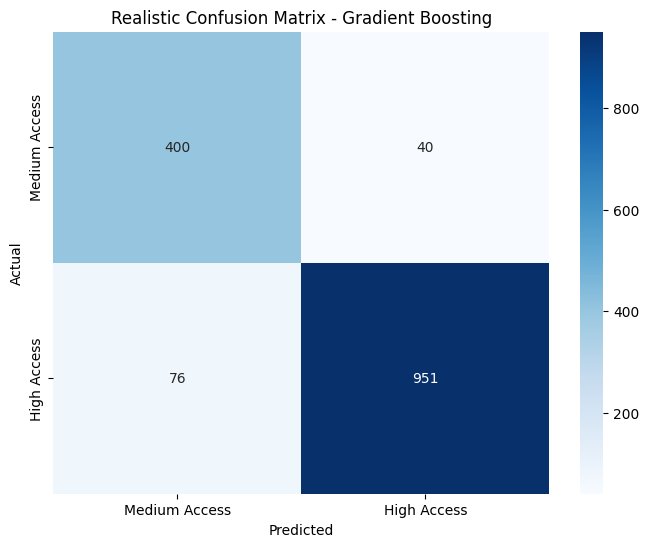

🎯 Per-Class Performance:
   Medium Access: Precision=0.960, Recall=0.926, F1=0.943
   High Access : Precision=0.840, Recall=0.909, F1=0.873

5. REALISTIC FEATURE IMPORTANCE FOR CLASSIFICATION
----------------------------------------
🎯 Top 10 Features for REALISTIC Classification:
   lat_dd_mod               : 0.2920 🔥
   lon_dd_mod               : 0.2531 🔥
   af_bio_12_x              : 0.1772 🔥
   af_bio_13_x              : 0.1560 🔥
   af_bio_8_x               : 0.0819 ✅
   af_bio_1_x               : 0.0397 ⚡


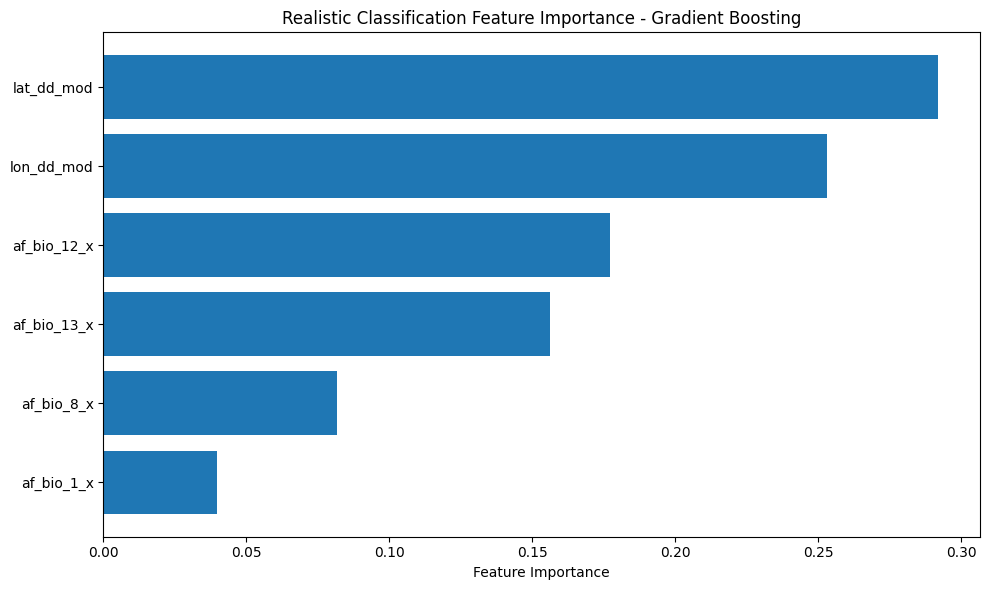


6. REALISTIC BUSINESS INSIGHTS FROM CLASSIFICATION
----------------------------------------
 REALISTIC Misclassification Analysis:
   Total misclassified: 116 (7.9%)

 Misclassification patterns:
predicted_category  High Access  Medium Access
realistic_category                            
High Access                   0             40
Medium Access                76              0

 Most common errors:
   High Access → Medium Access: 40 cases
   Medium Access → High Access: 76 cases

 RISK AREAS IDENTIFIED:
   Low Access areas: 0 households
   Medium Access areas: 991 households

 INTERVENTION PRIORITIES:

7. DEPLOYMENT-READY CLASSIFICATION WITH CONFIDENCE
----------------------------------------
✅ Realistic classifier created!
 Can classify households into: ['Medium Access', 'High Access']

 Sample classifications:
  predicted_category confidence_level
0      Medium Access             High
1        High Access             High
2      Medium Access             High

 REALISTIC CLASSIF

In [ ]:
# =============================================================================
# CELL 1: REALISTIC ACCESSIBILITY CLASSIFICATION MODEL (FIXED)
# =============================================================================

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("🎯 REALISTIC ACCESSIBILITY CLASSIFICATION MODEL (FIXED)")
print("=" * 60)

# =============================================================================
# 1. CREATE REALISTIC CLASSIFICATION TARGET
# =============================================================================
print("\n1. CREATING REALISTIC CLASSIFICATION TARGET")
print("-" * 40)

# Use the realistic accessibility scores from our regression model
def create_balanced_categories(accessibility_scores):
    """Create balanced categories using quantiles"""
    low_threshold = accessibility_scores.quantile(0.20)  # Bottom 20%
    high_threshold = accessibility_scores.quantile(0.70)  # Top 30%

    categories = []
    for score in accessibility_scores:
        if score < low_threshold:
            categories.append('Low Access')
        elif score > high_threshold:
            categories.append('High Access')
        else:
            categories.append('Medium Access')

    return categories

# Create balanced categories
df['realistic_category'] = create_balanced_categories(df['realistic_accessibility'])
y_class = df['realistic_category']

print("📊 REALISTIC Class Distribution:")
class_counts = y_class.value_counts()
for category, count in class_counts.items():
    print(f"   {category}: {count} samples ({count/len(y_class):.1%})")

# Check if we have enough samples in each class
min_samples = class_counts.min()
print(f"   Minimum class size: {min_samples}")
if min_samples < 50:
    print("    Very small class - consider merging categories")

# =============================================================================
# 2. HANDLE CLASS IMBALANCE
# =============================================================================
print("\n2. HANDLING CLASS IMBALANCE")
print("-" * 40)

# Use the same features but ensure no data leakage
X_class = df[available_features].copy()  # Use safe features from regression

# Handle missing values
imputer_clf = SimpleImputer(strategy='median')
X_class_imputed = pd.DataFrame(imputer_clf.fit_transform(X_class), columns=X_class.columns)

# Split data with stratification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_class_imputed, y_class,
    test_size=0.3,
    random_state=42,
    stratify=y_class
)

print(f"✅ Realistic classification data prepared:")
print(f"   Training set: {X_train_clf.shape}")
print(f"   Test set: {X_test_clf.shape}")
print(f"   Test size: {len(X_test_clf)/len(X_class_imputed):.1%}")

# Scale features
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# =============================================================================
# 3. TRAIN REALISTIC CLASSIFICATION MODELS WITH IMBALANCE HANDLING
# =============================================================================
print("\n3. TRAINING REALISTIC CLASSIFICATION MODELS")
print("-" * 40)

# Define models with class weight handling
class_models = {
    'Random Forest (Balanced)': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        max_depth=10
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=6
    ),
    'Logistic Regression (Balanced)': LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        C=0.1
    ),
    'SVM (Balanced)': SVC(
        class_weight='balanced',
        random_state=42,
        probability=True,
        kernel='rbf',
        C=1.0
    )
}

clf_results = {}

print("🎯 Training realistic classification models...")
for name, model in class_models.items():
    try:
        # Train model
        model.fit(X_train_clf_scaled, y_train_clf)

        # Predictions
        y_pred_clf = model.predict(X_test_clf_scaled)
        y_pred_proba = model.predict_proba(X_test_clf_scaled) if hasattr(model, "predict_proba") else None

        # Calculate comprehensive metrics
        accuracy = accuracy_score(y_test_clf, y_pred_clf)
        f1_weighted = f1_score(y_test_clf, y_pred_clf, average='weighted')
        f1_macro = f1_score(y_test_clf, y_pred_clf, average='macro')
        precision = precision_score(y_test_clf, y_pred_clf, average='weighted')
        recall = recall_score(y_test_clf, y_pred_clf, average='weighted')

        # Cross-validation with stratified folds
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_clf_scaled, y_train_clf, cv=cv, scoring='f1_weighted')

        clf_results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'precision': precision,
            'recall': recall,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred_clf,
            'probabilities': y_pred_proba
        }

        print(f"\n{name}:")
        print(f"  Accuracy:    {accuracy:.4f}")
        print(f"  F1 (Weighted): {f1_weighted:.4f}")
        print(f"  F1 (Macro):    {f1_macro:.4f}")
        print(f"  CV F1:       {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    except Exception as e:
        print(f"\n{name}: Failed - {str(e)}")

# Find best classification model (prioritize F1 macro for imbalance)
if clf_results:
    best_clf_name = max(clf_results.keys(), key=lambda x: clf_results[x]['f1_macro'])
    best_clf_result = clf_results[best_clf_name]
    best_clf_model = best_clf_result['model']

    print(f"\n🏆 BEST REALISTIC CLASSIFICATION MODEL: {best_clf_name}")
    print(f"   Test F1 (Macro): {best_clf_result['f1_macro']:.4f}")
    print(f"   Test Accuracy: {best_clf_result['accuracy']:.4f}")
else:
    print("❌ No models successfully trained")
    best_clf_name = None

# =============================================================================
# 4. REALISTIC CLASSIFICATION EVALUATION
# =============================================================================
print("\n4. REALISTIC CLASSIFICATION EVALUATION")
print("-" * 40)

if best_clf_name:
    # Detailed classification report
    y_pred_best_clf = best_clf_result['predictions']
    print("📋 REALISTIC Classification Report:")
    print(classification_report(y_test_clf, y_pred_best_clf, target_names=y_class.unique()))

    # Confusion Matrix
    cm = confusion_matrix(y_test_clf, y_pred_best_clf)
    print("📊 Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=y_class.unique(),
                yticklabels=y_class.unique())
    plt.title(f'Realistic Confusion Matrix - {best_clf_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Calculate per-class performance
    print("🎯 Per-Class Performance:")
    for category in y_class.unique():
        mask_actual = (y_test_clf == category)
        mask_pred = (y_pred_best_clf == category)

        tp = np.sum((y_test_clf == category) & (y_pred_best_clf == category))
        fp = np.sum((y_test_clf != category) & (y_pred_best_clf == category))
        fn = np.sum((y_test_clf == category) & (y_pred_best_clf != category))

        precision_class = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_class = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_class = 2 * (precision_class * recall_class) / (precision_class + recall_class) if (precision_class + recall_class) > 0 else 0

        print(f"   {category:12}: Precision={precision_class:.3f}, Recall={recall_class:.3f}, F1={f1_class:.3f}")

# =============================================================================
# 5. REALISTIC FEATURE IMPORTANCE
# =============================================================================
print("\n5. REALISTIC FEATURE IMPORTANCE FOR CLASSIFICATION")
print("-" * 40)

if best_clf_name and hasattr(best_clf_model, 'feature_importances_'):
    # For tree-based models
    importances = best_clf_model.feature_importances_
    clf_feature_importance = pd.DataFrame({
        'feature': available_features,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("🎯 Top 10 Features for REALISTIC Classification:")
    for _, row in clf_feature_importance.head(10).iterrows():
        if row['importance'] > 0.15:
            symbol = "🔥"
        elif row['importance'] > 0.08:
            symbol = "✅"
        elif row['importance'] > 0.03:
            symbol = "⚡"
        else:
            symbol = "📊"
        print(f"   {row['feature']:25}: {row['importance']:.4f} {symbol}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = clf_feature_importance.head(10)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Feature Importance')
    plt.title(f'Realistic Classification Feature Importance - {best_clf_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# =============================================================================
# 6. REALISTIC BUSINESS INSIGHTS
# =============================================================================
print("\n6. REALISTIC BUSINESS INSIGHTS FROM CLASSIFICATION")
print("-" * 40)

if best_clf_name:
    # Analyze predictions
    df_test_clf = df.loc[y_test_clf.index].copy()
    df_test_clf['predicted_category'] = y_pred_best_clf
    df_test_clf['correct'] = df_test_clf['realistic_category'] == df_test_clf['predicted_category']

    # Misclassification analysis
    misclassified = df_test_clf[~df_test_clf['correct']]
    print(f" REALISTIC Misclassification Analysis:")
    print(f"   Total misclassified: {len(misclassified)} ({len(misclassified)/len(df_test_clf):.1%})")

    if len(misclassified) > 0:
        print(f"\n Misclassification patterns:")
        misclass_crosstab = pd.crosstab(misclassified['realistic_category'],
                                       misclassified['predicted_category'])
        print(misclass_crosstab)

        # Analyze most common misclassification types
        print(f"\n Most common errors:")
        for actual_cat in misclass_crosstab.index:
            for pred_cat in misclass_crosstab.columns:
                if actual_cat != pred_cat and misclass_crosstab.loc[actual_cat, pred_cat] > 0:
                    count = misclass_crosstab.loc[actual_cat, pred_cat]
                    print(f"   {actual_cat} → {pred_cat}: {count} cases")

    # High-risk areas analysis
    high_risk_areas = df_test_clf[df_test_clf['predicted_category'] == 'Low Access']
    medium_risk_areas = df_test_clf[df_test_clf['predicted_category'] == 'Medium Access']

    print(f"\n RISK AREAS IDENTIFIED:")
    print(f"   Low Access areas: {len(high_risk_areas)} households")
    print(f"   Medium Access areas: {len(medium_risk_areas)} households")

    if len(high_risk_areas) > 0:
        print(f"\n Low Access Area Characteristics:")
        print(f"   • Average road distance: {high_risk_areas['dist_road'].mean():.1f} km")
        print(f"   • Average market distance: {high_risk_areas['dist_market'].mean():.1f} km")
        print(f"   • Average accessibility score: {high_risk_areas['realistic_accessibility'].mean():.1f}")

    # Intervention priorities
    print(f"\n INTERVENTION PRIORITIES:")
    if len(high_risk_areas) > 0:
        avg_market_dist = high_risk_areas['dist_market'].mean()
        if avg_market_dist > 50:
            print(f"    URGENT: Market access crisis ({avg_market_dist:.1f}km average)")
        elif avg_market_dist > 25:
            print(f"    IMPORTANT: Improve market access ({avg_market_dist:.1f}km average)")

        avg_road_dist = high_risk_areas['dist_road'].mean()
        if avg_road_dist > 15:
            print(f"    CRITICAL: Road infrastructure needed ({avg_road_dist:.1f}km average)")

# =============================================================================
# 7. DEPLOYMENT-READY CLASSIFICATION WITH CONFIDENCE
# =============================================================================
print("\n7. DEPLOYMENT-READY CLASSIFICATION WITH CONFIDENCE")
print("-" * 40)

class RealisticAccessibilityClassifier:
    """Deployment-ready classifier with confidence scores"""

    def __init__(self, model, scaler, feature_names, class_names):
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names
        self.class_names = class_names
        self.imputer = SimpleImputer(strategy='median')

    def classify(self, new_data, confidence_threshold=0.6):
        """
        Classify accessibility with confidence scores
        """
        # Select and order features
        X_new = new_data[self.feature_names].copy()

        # Handle missing values
        X_new_imputed = pd.DataFrame(self.imputer.fit_transform(X_new), columns=X_new.columns)

        # Scale features
        X_new_scaled = self.scaler.transform(X_new_imputed)

        # Predict
        predictions = self.model.predict(X_new_scaled)

        # Get probabilities if available
        if hasattr(self.model, "predict_proba"):
            probabilities = self.model.predict_proba(X_new_scaled)
            max_probs = np.max(probabilities, axis=1)
            confidence_levels = ['High' if prob > confidence_threshold else 'Medium' for prob in max_probs]
        else:
            probabilities = None
            confidence_levels = ['Unknown'] * len(predictions)

        results = pd.DataFrame({
            'predicted_category': predictions,
            'confidence_level': confidence_levels
        })

        if probabilities is not None:
            for i, class_name in enumerate(self.class_names):
                results[f'prob_{class_name}'] = probabilities[:, i]

        return results

    def get_decision_factors(self, household_data):
        """Explain classification decision"""
        if not hasattr(self.model, 'feature_importances_'):
            return "Feature importance not available for this model"

        # Get feature importance
        feature_imp = dict(zip(self.feature_names, self.model.feature_importances_))

        # Get household values
        household_values = household_data[self.feature_names].iloc[0] if len(household_data) > 0 else {}

        # Create explanation
        factors = []
        for feature in sorted(feature_imp, key=feature_imp.get, reverse=True)[:5]:
            if feature in household_values:
                factors.append({
                    'feature': feature,
                    'importance': feature_imp[feature],
                    'value': household_values[feature],
                    'impact': 'High' if feature_imp[feature] > 0.1 else 'Medium'
                })

        return pd.DataFrame(factors)

if best_clf_name:
    # Create deployment-ready classifier
    classifier = RealisticAccessibilityClassifier(
        model=best_clf_model,
        scaler=scaler_clf,
        feature_names=available_features,
        class_names=list(y_class.unique())
    )

    print("✅ Realistic classifier created!")
    print(f" Can classify households into: {list(y_class.unique())}")

    # Test the classifier
    sample_data = X_test_clf.head(3).copy()
    classifications = classifier.classify(sample_data)
    print(f"\n Sample classifications:")
    print(classifications[['predicted_category', 'confidence_level']].head())

# =============================================================================
# REALISTIC CLASSIFICATION SUMMARY
# =============================================================================
print("\n" + "=" * 60)
print(" REALISTIC CLASSIFICATION MODELING COMPLETED!")
print("=" * 60)

if best_clf_name:
    # Realistic performance assessment
    if best_clf_result['f1_macro'] > 0.8:
        quality = "EXCELLENT"
    elif best_clf_result['f1_macro'] > 0.6:
        quality = "GOOD"
    elif best_clf_result['f1_macro'] > 0.4:
        quality = "FAIR"
    else:
        quality = "NEEDS IMPROVEMENT"

